# Predicting NBA All-Stars

## Problem Statement

Despite having more access to data and information than ever before, front offices and scouting departments of professional sports teams still continue to struggle to make the correct draft choices. In professional sports, selecting the right player in the draft is critical to a team's future success. It is one of the best ways to build team depth in a cost efficient manner and it is where the fates of the best amateur athletes are decided. Drafting a player is an inexact science, but having a way to predict future success of a player will make a teams draft decision that much easier and will give them a leg up on the competition. In the NBA, having multiple players that are All-Stars on a team has been proven to lead to championships. The 2019 NBA champion Toronto Raptors had 3 former All-Stars on their roster (Kawhi Leonard, Kyle Lowry and Marc Gasol) and the Golden State Warriors, the best team of the decade, had 5 former All-Stars on their roster during their three championship runs (Steph Curry, Klay Thompson, Draymond Green, Kevin Durant and Andre Iguodala).

Our goal is to build a model that will predict the likelihood that a draft eligible College Basketball player will become an All-Star in the NBA. The process of becoming an All-Star has changed over the years, but currently the starting lineups for both teams are selected by a weighted combination of fan, player and media voting (50%, 25% and 25% respectively). The reserves are chosen by a vote between the coaches. We will look to predict the probability that a draft eligible College Basketball player by analyzing which features of a player lead to the future NBA success.


## Executive Summary

The goal of this project was to predict the probability that a draft eligible college basketball player will become an NBA All-Star at some point in his career. This was accomplished by utilizing data scraping, data cleaning, EDA, Bayesian statistics, preprocessing and classification modeling. The data used for the analysis was pulled from two websites, [Basketball Reference](https://www.sports-reference.com/cbb/play-index/psl_finder.cgi?request=1&match=combined&year_min=2006&year_max=2019&conf_id=&school_id=&class_is_fr=Y&class_is_so=Y&class_is_jr=Y&class_is_sr=Y&pos_is_g=Y&pos_is_gf=Y&pos_is_fg=Y&pos_is_f=Y&pos_is_fc=Y&pos_is_cf=Y&pos_is_c=Y&games_type=A&qual=&c1stat=&c1comp=&c1val=&c2stat=&c2comp=&c2val=&c3stat=&c3comp=&c3val=&c4stat=&c4comp=&c4val=&order_by=pts&order_by_asc=&offset=0) and [Bart Torvik](http://barttorvik.com). The process of pulling/scraping the data from the Basketball Reference website for the NBA draft data, All-Star data and single season data can be seen in the **Data_Collection** folder of the repository. Bart Torvik's data was collected through a JSON file provided by Bart himself. The process of organizing that data can also be seen in the **Data_Collection** folder. 

We were able to collect data on 55,939 individual college basketball seasons. This value includes every player that has played college basketball since 2008. If an individual played in multiple seasons, then they will have multiple observations listed for each season. International and high school athletes were not included in the analysis since the statistics are not an apples to apples comparison to college basketball. College basketball players also make up more than 83% of the players in the NBA ([RPI Ratings](http://rpiratings.com/NBA.php)). In the data cleaning process, we identified which players were drafted and which made an All-Star game. We also reduced the dataset to only include the final season a player played in college. Including all seasons for a player could affect my target variable since the player will be listed multiple times as having made an All-Star game. The last season someone played in college tends to be their best performing season and is what's looked at most heavily by a team's front office. Ultimately, the dataset included 581 individual college basketball seasons with 30 of the seasons having been All-Star players. The data collected for each player includes many individual statistics for that season as well as information on where the player went to school, conference and even physical measurements. 

Before building our model, we needed to understand the dataset in greater detail. In order to do this, we performed exploratory data analysis and used Bayesian MAP estimates to adjust certain features. We wanted to see what percentage of players made an All-Star game given a certain feature as well as what percentage of All-Stars had that feature. We also looked at the continuous features (players stats) by separating the data for players that have made an All-Star game and those who have not to see if there were any significant differences between the two. Before eliminating certain features that had overlap in their calculations, we calculated Bayesian MAP estimates to adjust several values. For example, **Free Throws Made (FTM)** and **Free Throws Attempted (FTA)** are used to calculate **Free Throw % (FT %)**. We adjusted the **FT %** using prior knowledge and a likelihood function before we dropped the **FTM** and **FTA** features. This provided us with a more accurate representation and helped account for players with far fewer attempts than other players. 

After completing EDA, we began the classification modeling process. We separated the data into a training and test set. The training data included players from 2008-2018 and the test set included college players from the 2019 NBA draft. We began by train/test splitting the training data after selecting features to include in the analysis. Then we began to build several classification models utilizing GridsearchCV to optimize for the best hyperparameters. Below is a list of the classification models used. 

- Logistic Regression  
- KNearest Neighbors 
- DecisionTree 
- RandomForest
- Adaboost

The best model had the highest accuracy and the lowest variance, but also had the most realistic and interpretable probabilities based off of prior knowledge. This model was then used to predict the All-Star probability on the 2019 test dataset.


## Data Dictionary
The majority of the data descriptions can be found [here](https://www.basketball-reference.com/about/glossary.html#mp) with the remainder on Bart Torvik's [site](https://www.bigtengeeks.com/new-stat-porpagatu/).

## Contents

- [Imports](#Imports)
- [Data Cleaning](#Data-Cleaning)
    - [Cleaning Draft Pick Data](#Cleaning-Draft-Pick-Data)
    - [Cleaning Single Season Data](#Cleaning-Single-Season-Data)
        - [Updating Player Names](#Updating-Player-Names)
        - [Indentifying All-Stars](#Identifying-All-Stars)
        - [Keeping Last Year Played in College](#Keeping-Last-Year-Played-in-College)
        - [Null Values](#Null-Values)
        - [Adjusting Height Column](#Adjusting-Height-Column) 
        - [Updating Conference Column](#Updating-Conference-Column)
        - [Creating Total Points and PPG Column](#Creating-Total-Points-and-PPG-Column)
        - [Creating Position Column](#Creating-Position-Column)
        - [Adjusting Yr Column](#Adjusting-Yr-Column)
- [EDA](#EDA)
    - [Descriptive Statistics & Visualizations](#Descriptive-Statistics-&-Visualizations)
    - [Creating Dummy Columns](#Creating-Dummy-Columns)
    - [More EDA After Modeling](#More-EDA-After-Modeling)
    

    


## Imports

In [1]:
#import libraries
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt
import seaborn           as sns
import scipy.stats       as stats

import warnings
warnings.filterwarnings("ignore")

sns.set_style("whitegrid")



#adjusting display to see more data for convenience
pd.set_option('display.max_rows', 600)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 500)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

## Data Cleaning

### Cleaning Draft Pick Data

In [2]:
# reading in NBA draft picks data since 2008
draft_picks = pd.read_csv('../Data_Files/draftpicks.csv', index_col = 0)
draft_picks.head()

,Pk,Tm,Player,College,Yrs,G,MP,PTS,TRB,AST,FG%,3P%,FT%,MP.1,PTS.1,TRB.1,AST.1,WS,WS/48,BPM,VORP
0,1,CHI,Derrick Rose,University of Memphis,10.0,546.0,18104.0,10281.0,1910.0,3056.0,0.453,0.304,0.824,33.2,18.8,3.5,5.6,37.2,0.099,0.3,10.5
1,2,MIA,Michael Beasley,Kansas State University,11.0,609.0,13903.0,7568.0,2861.0,788.0,0.465,0.349,0.759,22.8,12.4,4.7,1.3,15.6,0.054,-3.2,-4.3
2,3,MIN,O.J. Mayo,University of Southern California,8.0,547.0,16919.0,7574.0,1706.0,1607.0,0.429,0.373,0.820,30.9,13.8,3.1,2.9,21.8,0.062,-0.8,5.1
3,4,SEA,Russell Westbrook,"University of California, Los Angeles",11.0,821.0,28330.0,18859.0,5760.0,6897.0,0.434,0.308,0.801,34.5,23.0,7.0,8.4,96.9,0.164,6.6,61.6
4,5,MEM,Kevin Love,"University of California, Los Angeles",11.0,657.0,21023.0,12006.0,7397.0,1519.0,0.442,0.370,0.827,32.0,18.3,11.3,2.3,78.2,0.179,2.7,24.9


In [3]:
draft_picks.shape

(720, 21)

In [4]:
#removing columns passed college. Unneccesary for my analysis
draft_picks = draft_picks[draft_picks.columns[:4]]

In [5]:
draft_picks.head()

,Pk,Tm,Player,College
0,1,CHI,Derrick Rose,University of Memphis
1,2,MIA,Michael Beasley,Kansas State University
2,3,MIN,O.J. Mayo,University of Southern California
3,4,SEA,Russell Westbrook,"University of California, Los Angeles"
4,5,MEM,Kevin Love,"University of California, Los Angeles"


In [6]:
draft_picks.isnull().sum()

Pk           0
Tm           0
Player       0
College    137
dtype: int64

In [7]:
#dropping international players from analysis. 
draft_picks = draft_picks[draft_picks['College'].notnull()]

We have decided to remove international players from our analysis. It is not an apples to apples comparison when comparing international player stats compared to college basketball.

In [8]:
draft_picks.shape

(583, 4)

In [9]:
#may be some duplicates
draft_picks['Player'].nunique()

581

In [10]:
draft_picks[draft_picks.duplicated('Player', keep = False)]

,Pk,Tm,Player,College
106,43,MIA,Marcus Thornton,Louisiana State University
480,45,BOS,Marcus Thornton,College of William & Mary
572,15,POR,Justin Jackson,University of North Carolina
664,43,DEN,Justin Jackson,University of Maryland


Two players drafted happened to have the same name. We wanted to make sure that there weren't any duplicates in the dataset.

### Cleaning Single Season Data

I will be using the data from Bart Torvik's website for my analysis. The data includes all stats for all players that have played college basketball since 2008.

In [11]:
#reading in file
single_season_df = pd.read_csv('../Data_Files/torvik_data.csv', index_col = 0)

In [12]:
single_season_df.head()

,player_name,school,conference,GP,Min_per,ORtg,usg,eFG,TS_per,ORB_per,DRB_per,AST_per,TO_per,FTM,FTA,FT_per,twoPM,twoPA,twoP_per,TPM,TPA,TP_per,blk_per,stl_per,ftr,yr,ht,num,porpag,adjoe,pfr,year,pid,type,rec-rk,ast/tov,rimmade,rimmade + rimmiss,midmade,midmade + midmiss,rimmade/(rimmade+rimmiss),midmade/(midmade+mismiss),dunksmade,dunksmiss + dunksmade,dunksmade/(dunksmade+dunksmiss),pick,drtg,adrtg,dporpag,stops,bpm,obpm,dbpm,gbpm,mp,ogbpm,dgbpm
0,Jason Praet,Detroit,Horz,6,1.0,0.0,16.8,0.0,0.00,0.0,11.4,0.0,32.9,0,0,0.000,0,2,0.000,0,1,0.000,0.0,5.5,0.0,So,6-7,NaN,-0.590891,-0.385791,13.3,2008,1,all,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.724,98.5024,0.196087,2.50101,-16.14070,-14.74150,-1.39926,-19.178,2.0000,-21.543,2.365
1,DeAndrae Ross,South Alabama,SB,22,8.4,62.0,14.1,32.6,33.40,0.0,5.4,6.6,32.1,1,2,0.500,3,12,0.250,3,11,0.273,0.0,1.1,8.7,Fr,6-2,NaN,-0.490631,55.131900,6.1,2008,2,all,NaN,0.624962,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,103.960,104.6870,0.365511,15.03790,-8.33266,-6.31752,-2.01514,-10.622,5.1250,-9.557,-1.065
2,DeAndrae Ross,South Alabama,SB,26,29.5,97.3,16.6,42.5,44.43,1.6,4.6,15.8,16.3,10,14,0.714,26,68,0.382,13,39,0.333,0.3,1.5,13.1,So,6-2,NaN,0.258086,89.393800,2.5,2009,2,all,NaN,1.823646,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,108.321,108.5270,0.893017,49.96440,-5.15203,-1.77499,-3.37704,-4.381,14.5769,-2.722,-1.659
3,DeAndrae Ross,Troy,SB,7,11.5,67.1,16.9,34.5,36.11,3.1,6.8,13.8,32.8,3,6,0.500,4,11,0.364,4,18,0.222,0.0,0.4,20.7,Jr,6-2,13,-1.232000,65.762800,4.2,2011,2,all,NaN,0.769264,1.0,2.0,3.0,9.0,0.5,0.3333,0.0,0.0,NaN,NaN,113.707,111.9560,0.962461,17.44340,-10.44550,-6.83856,-3.60694,-9.617,18.8571,-6.524,-3.093
4,Pooh Williams,Utah St.,WAC,28,24.3,93.1,13.8,45.2,46.20,1.4,6.6,14.3,22.9,7,13,0.538,16,39,0.410,8,23,0.348,0.6,1.7,21.0,Fr,6-4,NaN,-0.051861,83.492700,3.3,2008,3,all,NaN,1.449906,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,108.419,110.3660,0.672348,48.48480,-3.29203,-1.17901,-2.11302,-3.537,12.1379,-2.517,-1.020


In [13]:
#checking to make sure all players drafted are in the scraped dataset from Bart Torvik
player_list = []

for player in draft_picks['Player']:
    if player in set(single_season_df['player_name']):
        player_list.append(player)

In [14]:
len(set(player_list))

548

There must be some drafted players missing from our list since the length of the list does not equal the length of drafted players.

In [15]:
missing = []
for player in draft_picks['Player']:
    if player not in set(single_season_df['player_name']):
        missing.append(player)


In [16]:
len(missing)

33

In [17]:
#List of names not showing up in the single season stats dataframe
missing

['J.J. Hickson',
 'Donté Greene',
 'Patrick Ewing',
 'Greivis Vásquez',
 "Hamady N'Diaye",
 'Nikola Vučević',
 'Maurice Harkless',
 'Perry Jones',
 'CJ McCollum',
 'Tim Hardaway',
 'Ricky Ledo',
 "Johnny O'Bryant",
 'Glenn Robinson',
 'Devyn Marble',
 'Larry Nance',
 'Joe Young',
 'Jakob Pöltl',
 'Taurean Waller-Prince',
 'Wade Baldwin',
 'Skal Labissière',
 'Stephen Zimmerman',
 'Kay Felder',
 'Dennis Smith',
 'Bam Adebayo',
 'T.J. Leaf',
 'Marvin Bagley',
 'Jaren Jackson',
 'Wendell Carter',
 'Lonnie Walker',
 'Jacob Evans',
 'Gary Trent',
 'RJ Barrett',
 'Dewan Hernandez']

Above is a list of the players missing from our dataset. All should be included since our data includes all single season stats for college seasons played since 2008. We are going to check if there are reasons why they are missing. Our belief is that the names above are spelt differently in the two datasets. 

In [18]:
#checking to see if the players above are really in the dataset. The code below will check by name
single_season_df[single_season_df['player_name'].str.contains('Bagley')]

,player_name,school,conference,GP,Min_per,ORtg,usg,eFG,TS_per,ORB_per,DRB_per,AST_per,TO_per,FTM,FTA,FT_per,twoPM,twoPA,twoP_per,TPM,TPA,TP_per,blk_per,stl_per,ftr,yr,ht,num,porpag,adjoe,pfr,year,pid,type,rec-rk,ast/tov,rimmade,rimmade + rimmiss,midmade,midmade + midmiss,rimmade/(rimmade+rimmiss),midmade/(midmade+mismiss),dunksmade,dunksmiss + dunksmade,dunksmade/(dunksmade+dunksmiss),pick,drtg,adrtg,dporpag,stops,bpm,obpm,dbpm,gbpm,mp,ogbpm,dgbpm
52240,Marvin Bagley III,Duke,ACC,33,74.8,123.8,25.8,64.0,64.35,13.8,21.4,8.8,14.7,131,209,0.627,247,382,0.647,23,58,0.397,2.6,1.4,47.5,Fr,6-11,35,6.05772,139.562,2.2,2018,50726,all,100.0,0.666696,193.0,264.0,54.0,118.0,0.7311,0.4576,94.0,98.0,0.9592,2.0,96.4998,91.4735,4.41577,234.046,9.11842,6.74289,2.37553,9.999,33.7576,8.686,1.313


In [19]:
#code will look for players by college
single_season_df[single_season_df['school'].str.contains('Miami')].head()

,player_name,school,conference,GP,Min_per,ORtg,usg,eFG,TS_per,ORB_per,DRB_per,AST_per,TO_per,FTM,FTA,FT_per,twoPM,twoPA,twoP_per,TPM,TPA,TP_per,blk_per,stl_per,ftr,yr,ht,num,porpag,adjoe,pfr,year,pid,type,rec-rk,ast/tov,rimmade,rimmade + rimmiss,midmade,midmade + midmiss,rimmade/(rimmade+rimmiss),midmade/(midmade+mismiss),dunksmade,dunksmiss + dunksmade,dunksmade/(dunksmade+dunksmiss),pick,drtg,adrtg,dporpag,stops,bpm,obpm,dbpm,gbpm,mp,ogbpm,dgbpm
708,James Dews,Miami FL,ACC,33,71.1,120.7,15.8,52.2,55.92,2.9,7.9,12.3,10.1,49,54,0.907,60,122,0.492,55,151,0.364,0.9,1.5,19.8,So,6-4,NaN,3.385210,119.0460,3.6,2008,367,all,80.2,2.178628,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,102.1860,98.4398,2.795630,152.5870,6.05044,5.16577,0.884668,5.554,28.4706,3.693,1.861
709,James Dews,Miami FL,ACC,31,62.4,109.9,16.3,48.9,51.30,2.1,9.9,10.4,13.5,31,41,0.756,49,104,0.471,43,128,0.336,0.6,1.8,17.7,Jr,6-4,NaN,2.045210,107.8840,3.3,2009,367,all,80.2,1.379262,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,101.6300,96.1422,2.608740,128.7260,3.48320,2.49664,0.986557,3.408,25.2581,1.540,1.868
710,James Dews,Miami FL,ACC,32,73.9,108.4,18.8,51.6,53.34,2.3,9.2,11.2,14.0,35,47,0.745,93,181,0.514,47,136,0.346,0.7,2.0,14.8,Sr,6-4,23,2.754340,111.3550,2.7,2010,367,all,80.2,1.214324,36.0,55.0,57.0,126.0,0.6545,0.4524,0.0,0.0,NaN,NaN,100.9670,98.7474,2.847400,150.2440,3.09003,3.37256,-0.282532,3.394,29.5625,2.760,0.634
712,Fabio Nass,Miami FL,ACC,8,4.0,104.8,17.4,66.7,68.97,8.5,20.1,7.4,31.6,5,7,0.714,6,8,0.750,0,1,0.000,8.0,2.2,77.8,Sr,6-11,NaN,0.338249,99.4706,4.5,2008,369,all,NaN,0.799856,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,91.1741,95.6060,0.716121,13.0988,6.57472,0.41026,6.164460,1.750,6.3333,-1.401,3.151
1008,Tim Pollitz,Miami OH,MAC,33,87.1,107.0,27.6,54.2,56.08,9.2,16.8,22.7,18.9,74,111,0.667,209,384,0.544,6,18,0.333,1.8,2.2,27.6,Sr,6-5,NaN,4.429600,121.4130,2.9,2008,523,all,NaN,1.109878,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,97.4584,94.6748,3.876930,209.3030,5.91064,3.46165,2.448990,5.104,35.4848,4.204,0.900


In [20]:
#code will check for players by name and college
single_season_df[single_season_df['school'].str.contains('Michigan') & single_season_df['player_name'].str.contains('Hardaway')]


,player_name,school,conference,GP,Min_per,ORtg,usg,eFG,TS_per,ORB_per,DRB_per,AST_per,TO_per,FTM,FTA,FT_per,twoPM,twoPA,twoP_per,TPM,TPA,TP_per,blk_per,stl_per,ftr,yr,ht,num,porpag,adjoe,pfr,year,pid,type,rec-rk,ast/tov,rimmade,rimmade + rimmiss,midmade,midmade + midmiss,rimmade/(rimmade+rimmiss),midmade/(midmade+mismiss),dunksmade,dunksmiss + dunksmade,dunksmade/(dunksmade+dunksmiss),pick,drtg,adrtg,dporpag,stops,bpm,obpm,dbpm,gbpm,mp,ogbpm,dgbpm
17410,Tim Hardaway Jr,Michigan,B10,34,76.7,109.8,24.3,52.4,56.04,3.0,11.7,12.6,11.1,89,117,0.761,80,167,0.479,76,203,0.374,0.6,2.1,31.6,Fr,6-5,10,3.94305,121.958,2.5,2011,14888,all,68.0,1.340932,44.0,61.0,36.0,106.0,0.7213,0.3396,12.0,13.0,0.9231,24.0,100.338,92.5654,3.65885,175.922,6.29843,4.93351,1.364930,7.748,30.9118,5.443,2.305
17411,Tim Hardaway Jr.,Michigan,B10,33,84.7,103.4,25.7,48.6,52.69,3.1,11.5,13.9,14.7,106,148,0.716,112,207,0.541,51,181,0.282,1.0,0.9,38.1,So,6-5,10,3.74755,116.218,2.5,2012,14888,all,68.0,1.076915,56.0,87.0,56.0,120.0,0.6437,0.4667,11.0,12.0,0.9167,24.0,103.382,97.1034,3.43895,167.135,2.88399,2.71698,0.167008,3.824,34.2727,3.232,0.592
17412,Tim Hardaway Jr.,Michigan,B10,37,84.2,104.9,22.3,50.4,52.71,0.8,14.5,12.9,15.0,73,105,0.695,125,260,0.481,68,190,0.358,1.4,1.2,23.3,Jr,6-6,10,3.76564,115.272,2.2,2013,14888,all,68.0,1.304306,63.0,85.0,62.0,175.0,0.7412,0.3543,20.0,22.0,0.9091,24.0,99.600,93.4428,3.89680,214.122,4.25108,2.92356,1.327510,5.135,34.9459,3.712,1.423


Tim Hardaway is an example of a player that was "missing" in our dataset. As you can see above, the scraped data includes "Jr." in his name. One of the observations also lists his name without the period after Jr. We are going to update this for consistency.

In [21]:
#updating Tim Hardaway Jr. name to be consistent with the other two ways it is spelt
single_season_df.loc[single_season_df['player_name'] == 'Tim Hardaway Jr', 'player_name'] = 'Tim Hardaway Jr.'

In [22]:
#checking correction
single_season_df.loc[single_season_df['player_name'] == 'Tim Hardaway Jr.', 'player_name']

17410    Tim Hardaway Jr.
17411    Tim Hardaway Jr.
17412    Tim Hardaway Jr.
Name: player_name, dtype: object

We noticed in my EDA that Trent Plaisted was not listed as drafted in our dataset which is incorrect. That value will need to be imputed.

In [23]:
single_season_df[single_season_df['player_name'].str.contains('Plaisted')]

,player_name,school,conference,GP,Min_per,ORtg,usg,eFG,TS_per,ORB_per,DRB_per,AST_per,TO_per,FTM,FTA,FT_per,twoPM,twoPA,twoP_per,TPM,TPA,TP_per,blk_per,stl_per,ftr,yr,ht,num,porpag,adjoe,pfr,year,pid,type,rec-rk,ast/tov,rimmade,rimmade + rimmiss,midmade,midmade + midmiss,rimmade/(rimmade+rimmiss),midmade/(midmade+mismiss),dunksmade,dunksmiss + dunksmade,dunksmade/(dunksmade+dunksmiss),pick,drtg,adrtg,dporpag,stops,bpm,obpm,dbpm,gbpm,mp,ogbpm,dgbpm
2604,Trent Plaisted,BYU,MWC,34,66.7,101.7,30.3,54.5,55.06,9.4,21.2,13.8,16.8,136,252,0.54,200,367,0.545,0,0,0.0,3.7,0.9,68.7,Jr,6-11,NaN,3.00681,116.315,3.3,2008,1309,all,73.8,0.658512,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,89.2706,88.2009,3.67358,201.822,2.80707,-0.376679,3.18375,4.812,27.5588,2.683,2.129


In [24]:
single_season_df.loc[single_season_df['player_name'] == 'Trent Plaisted', 'pick'] = 46

In [25]:
single_season_df.loc[single_season_df['player_name'] == 'Trent Plaisted', 'pick']

2604    46.0
Name: pick, dtype: float64

#### Updating Player Names

In [26]:
#name change dictionary
#So both dataframes are consistent
name_changes = {'J.J. Hickson': "JJ Hickson",
                'Donté Greene': 'Donte Greene',
                'Patrick Ewing': 'Patrick Ewing Jr.',
                'Greivis Vásquez': 'Greivis Vasquez',
                "Hamady N'Diaye": 'Hamady Ndiaye',
                'Nikola Vučević': 'Nikola Vucevic',
                'Maurice Harkless': 'Moe Harkless',
                'Perry Jones': 'Perry Jones III',
                'CJ McCollum': 'C.J. McCollum',
                'Tim Hardaway': 'Tim Hardaway Jr.',
                "Johnny O'Bryant": "Johnny O'Bryant III",
                'Glenn Robinson': 'Glenn Robinson III',
                'Devyn Marble': 'Roy Devyn Marble',
                'Larry Nance': 'Larry Nance Jr.',
                'Joe Young': 'Joseph Young',
                'Jakob Pöltl': 'Jakob Poeltl',
                'Taurean Waller-Prince': 'Taurean Prince',
                'Wade Baldwin': 'Wade Baldwin IV',
                'Skal Labissière': 'Skal Labissiere',
                'Stephen Zimmerman': 'Stephen Zimmerman Jr.',
                'Kay Felder': 'Kahlil Felder',
                'Dennis Smith': 'Dennis Smith, Jr.',
                'Bam Adebayo': 'Edrice Adebayo',
                'T.J. Leaf': 'TJ Leaf',
                'Marvin Bagley': 'Marvin Bagley III',
                'Jaren Jackson': 'Jaren Jackson Jr.',
                'Wendell Carter': 'Wendell Carter Jr.',
                'Lonnie Walker': 'Lonnie Walker IV',
                'Jacob Evans': 'Jacob Evans III',
                'Gary Trent': 'Gary Trent Jr.',
                'RJ Barrett': 'R.J. Barrett',
                'Dewan Hernandez': 'Dewan Huell',
                'Michael Porter' : 'Michael Porter Jr.'}

In [27]:
#updating names in drafted players list
for player in draft_picks['Player']:
    if player in name_changes.keys():
        draft_picks.loc[draft_picks['Player'] == player, 'Player'] = name_changes[player]
    else:
        pass
        

In [28]:
still_missing = []
for player in draft_picks['Player']:
    if player not in set(single_season_df['player_name']):
        still_missing.append(player)


In [29]:
still_missing

['Ricky Ledo']

All the names have been corrected. Ricky Ledo is still missing because he did not play in college and therefore has no stats. He will not be included in our analysis

In [30]:
#updating dataframe to only include drafted players
single_season_df = single_season_df[single_season_df['player_name'].isin(draft_picks['Player'])]

In [31]:
#checking null values in pick column
single_season_df['pick'].isnull().sum()

117

The pick column should have zero null values since all players in the dataset were drafted. We are going to check to see if there are more situations of players having the same name but went to different schools. The players not drafted will be removed.

In [32]:
single_season_df[single_season_df['pick'].isnull()].head()

,player_name,school,conference,GP,Min_per,ORtg,usg,eFG,TS_per,ORB_per,DRB_per,AST_per,TO_per,FTM,FTA,FT_per,twoPM,twoPA,twoP_per,TPM,TPA,TP_per,blk_per,stl_per,ftr,yr,ht,num,porpag,adjoe,pfr,year,pid,type,rec-rk,ast/tov,rimmade,rimmade + rimmiss,midmade,midmade + midmiss,rimmade/(rimmade+rimmiss),midmade/(midmade+mismiss),dunksmade,dunksmiss + dunksmade,dunksmade/(dunksmade+dunksmiss),pick,drtg,adrtg,dporpag,stops,bpm,obpm,dbpm,gbpm,mp,ogbpm,dgbpm
15,Anthony Brown,Pacific,BW,30,65.0,105.1,22.0,54.9,60.20,8.5,25.2,5.6,21.9,116,169,0.686,99,182,0.544,1,1,1.000,1.2,1.3,92.3,Jr,6-8,NaN,1.86078,105.3950,3.3,2008,9,all,NaN,0.380948,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,98.4147,100.7860,2.34157,155.975,-1.91317,-1.40390,-0.509274,0.432,26.2581,0.687,-0.255
16,Anthony Brown,Pacific,BW,33,56.2,96.5,22.0,52.8,54.31,8.3,18.6,8.2,22.7,64,114,0.561,93,176,0.528,0,0,0.000,1.9,1.3,64.8,Sr,6-8,NaN,1.06013,97.8554,3.8,2009,9,all,NaN,0.491229,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,101.0520,100.7240,1.99279,128.028,-1.92168,-2.02879,0.107110,-1.795,22.9091,-1.110,-0.685
1081,Ryan Anderson,Nebraska,B12,33,73.2,109.0,15.5,53.0,55.38,4.7,16.8,11.9,17.1,32,40,0.800,48,96,0.500,50,136,0.368,0.1,3.0,17.2,So,6-4,NaN,2.15944,106.0080,3.5,2008,560,all,54.0,1.357193,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,91.6976,88.5437,3.88301,195.440,6.17091,3.09500,3.075910,4.974,29.7273,1.827,3.147
1082,Ryan Anderson,Nebraska,B12,30,57.8,103.6,18.3,49.4,52.53,3.9,17.0,17.6,14.7,36,50,0.720,39,82,0.476,33,97,0.340,0.6,3.6,27.9,Jr,6-4,NaN,1.65514,104.2520,4.9,2009,560,all,54.0,1.838769,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,90.6588,86.3613,3.30495,149.817,6.20362,2.10072,4.102900,5.564,23.9667,1.404,4.160
1083,Ryan Anderson,Nebraska,B12,31,65.0,108.7,21.7,55.8,58.91,5.1,18.5,17.8,19.0,63,84,0.750,63,132,0.477,54,126,0.429,0.9,3.8,32.6,Sr,6-4,44,3.01439,115.8880,3.7,2010,560,all,54.0,1.172368,26.0,34.0,37.0,98.0,0.7647,0.3776,1.0,1.0,1.0,NaN,95.5260,92.0187,3.31237,185.140,7.97947,4.89105,3.088410,7.511,27.9032,4.542,2.969


As expected there are several players with the same names. The players not drafted will be removed.

In [33]:
#removing rows with null values in pick column
single_season_df = single_season_df[single_season_df['pick'].notnull()]

In [34]:
single_season_df['pick'].isnull().sum()

0

In [35]:
set(draft_picks['Player']) - set(single_season_df['player_name'])

{'Mike Taylor', 'Ricky Ledo'}

Two players are missing. Ricky Ledo, which as stated before, makes sense since he did not play in college. Mike Taylor was kicked off his college team in 2007 so we don't have data on him since it was prior to 2008.

#### Identifying All-Star Players

In [36]:
#reading in file
all_star = pd.read_csv('../Data_Files/all_star_rosters.csv', index_col = 0)

In [37]:
all_star.head()

,Name
0,Dwyane Wade
1,LeBron James
2,Allen Iverson
3,Shaquille O'Neal
4,Vince Carter


In [38]:
#Making sure that the names are spelt in the same way between the list of all-stars and the single season stats.
all_stars = []
for player in all_star['Name']:
    if player in set(single_season_df['player_name']):
        all_stars.append(player)

In [39]:
all_stars

['Derrick Rose',
 'Blake Griffin',
 'Russell Westbrook',
 'Kevin Love',
 'Roy Hibbert',
 'James Harden',
 'Kyrie Irving',
 'Paul George',
 'Jrue Holiday',
 'Brook Lopez',
 'John Wall',
 'DeMar DeRozan',
 'Stephen Curry',
 'Anthony Davis',
 'Damian Lillard',
 'Klay Thompson',
 'DeMarcus Cousins',
 'Jeff Teague',
 'Jimmy Butler',
 'Kawhi Leonard',
 'Draymond Green',
 'Isaiah Thomas',
 'Andre Drummond',
 'Gordon Hayward',
 'DeAndre Jordan',
 'Kemba Walker',
 'Bradley Beal',
 'Victor Oladipo',
 'Joel Embiid',
 'Karl-Anthony Towns']

All college players drafted since 2008 that have made an All-Star team are listed above. All other players in the All-Star dataframe were either drafted prior to 2008 or played internationally.

In [40]:
#creating a column in the df if the player made an all-star game. This is the target column.
single_season_df['all_star'] = single_season_df['player_name'].map(lambda x: 1 if x in set(all_star['Name']) else 0)



In [41]:
single_season_df['all_star'].value_counts()

0    1292
1      53
Name: all_star, dtype: int64

In [42]:
single_season_df[single_season_df['all_star'] == 1]

,player_name,school,conference,GP,Min_per,ORtg,usg,eFG,TS_per,ORB_per,DRB_per,AST_per,TO_per,FTM,FTA,FT_per,twoPM,twoPA,twoP_per,TPM,TPA,TP_per,blk_per,stl_per,ftr,yr,ht,num,porpag,adjoe,pfr,year,pid,type,rec-rk,ast/tov,rimmade,rimmade + rimmiss,midmade,midmade + midmiss,rimmade/(rimmade+rimmiss),midmade/(midmade+mismiss),dunksmade,dunksmiss + dunksmade,dunksmade/(dunksmade+dunksmiss),pick,drtg,adrtg,dporpag,stops,bpm,obpm,dbpm,gbpm,mp,ogbpm,dgbpm,all_star
2836,Brook Lopez,Stanford,P10,27,56.8,110.6,32.0,46.8,53.69,11.1,19.3,11.3,13.5,153,194,0.789,184,387,0.475,0,6,0.000,6.8,1.2,49.4,So,7-0,NaN,5.36516,135.985,3.2,2008,1417,all,98.2,0.637959,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,90.0045,82.7728,4.60650,176.8620,7.59980,3.128780,4.471020,9.835,30.7407,6.702,3.133,1
3255,Jeff Teague,Wake Forest,ACC,29,70.8,103.1,24.6,47.8,54.37,1.8,8.2,17.8,20.3,110,138,0.797,97,217,0.447,29,77,0.377,2.0,3.6,46.9,Fr,6-2,NaN,2.99292,114.195,3.2,2008,1633,all,90.0,0.986480,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.0,97.5231,94.6201,3.26730,170.1810,4.16692,2.150410,2.016520,4.778,29.5517,1.957,2.821,1
3256,Jeff Teague,Wake Forest,ACC,31,79.9,113.1,26.2,54.6,61.47,1.7,8.6,20.2,21.0,179,219,0.817,135,269,0.502,45,102,0.441,2.0,3.1,59.0,So,6-2,NaN,4.56874,125.453,2.7,2009,1633,all,90.0,1.057708,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.0,95.1768,90.6154,3.95475,203.1860,6.95495,5.136570,1.818380,8.296,31.9677,5.386,2.910,1
3648,Stephen Curry,Davidson,SC,35,83.6,120.8,31.7,60.1,63.50,2.6,13.4,18.8,14.4,133,149,0.893,150,280,0.536,157,361,0.435,1.2,3.6,23.2,So,6-3,NaN,6.60436,141.692,2.9,2008,1827,all,49.0,1.118298,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,91.0515,89.7066,4.29774,247.8700,12.67340,10.316000,2.357390,14.339,33.1389,11.628,2.711,1
3649,Stephen Curry,Davidson,SC,33,82.1,118.0,37.5,54.9,60.46,1.8,12.3,39.8,16.6,212,241,0.880,176,340,0.518,127,327,0.388,0.7,3.9,36.1,Jr,6-3,NaN,6.66086,141.028,2.8,2009,1827,all,49.0,1.431981,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,89.1128,88.3785,4.44618,253.6200,13.57200,10.900400,2.671600,12.586,33.8182,9.736,2.850,1
5576,Blake Griffin,Oklahoma,B12,33,66.2,109.8,28.6,56.8,57.95,13.9,24.0,16.7,17.4,116,197,0.589,184,322,0.571,0,2,0.000,3.4,2.2,60.8,Fr,6-10,NaN,4.22939,128.171,3.5,2008,2804,all,97.0,0.802649,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,92.0232,86.8530,3.88744,207.0710,8.20708,4.342970,3.864110,7.789,28.3939,5.735,2.054,1
5577,Blake Griffin,Oklahoma,B12,35,80.6,117.6,31.1,65.7,64.77,14.2,32.2,16.3,18.2,191,324,0.590,297,451,0.659,3,8,0.375,3.6,1.9,70.6,So,6-10,NaN,6.39363,139.820,3.1,2009,2804,all,97.0,0.689648,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,87.4256,82.5913,5.02664,316.5600,12.02840,7.571450,4.456920,12.633,33.2857,10.037,2.596,1
5817,Russell Westbrook,UCLA,P10,38,84.6,109.0,22.5,49.3,53.28,5.9,8.4,24.0,19.9,105,148,0.709,153,308,0.497,24,75,0.320,0.6,2.9,38.6,So,6-3,NaN,3.87651,117.773,2.9,2008,2935,all,72.8,1.739630,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,92.6743,86.9080,4.67871,224.9810,7.31577,4.044480,3.271290,6.543,33.7949,3.187,3.356,1
5996,Roy Hibbert,Georgetown,BE,34,65.3,119.2,25.6,61.4,62.64,11.3,17.0,16.6,15.7,93,144,0.646,176,291,0.605,3,3,1.000,9.7,1.3,49.0,Sr,7-2,NaN,4.40240,133.308,4.1,2008,3031,all,71.2,1.105219,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.0,88.6449,83.9796,3.87887,183.7850,11.77280,4.743730,7.029040,11.109,26.3235,6.852,4.257,1
6010,Kevin Love,UCLA,P10,38,74.1,127.0,27.2,59.2,64.24,15.3,28.6,13.8,14.8,193,251,0.769,191,314,0.608,29,82,0.354,5.0,1.5,63.4,Fr,6-10,NaN,6.25055,145.531,2.6,2008,3038,all,99.4,0.961550,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,85.7310,80.3968,4.76808,256.4420,14.18950,8.810980,5.378510,14.674,29.6410,10.849,3.825,1


The single-season dataframe now includes all the data for the players we are looking to use. 

In [43]:
single_season_df.shape

(1345, 58)

#### Keeping Last Year Played in College

In our dataset, each season that a player played in college is listed as a separate line item. This is going to skew our data and analysis since a player that has made an All-Star team in the NBA and played multiple seasons in college will be listed multiple times as having made the All-Star game. In order to enhance our analysis, we are going to only keep the last year a player played in college. That season is most used by front offices and scouts when evaluating talent for the NBA. This tends to be a players best performing season in college.

In [44]:
#dropping duplicates and keeping last
#pid is a unique identifier for each player
single_season_df.drop_duplicates('pid' , keep = 'last', inplace = True)

In [45]:
single_season_df.shape

(581, 58)

In [46]:
single_season_df['pid'].nunique()

581

Dataframe now only has one season's worth of data for each player.

In [47]:
#updating Damian Lillard's year in college to senior. Value was incorrect in the data.
single_season_df.loc[single_season_df['player_name'] == 'Damian Lillard', 'yr'] = 'Sr'

In [48]:
single_season_df.loc[single_season_df['player_name'] == 'Damian Lillard', 'yr']

8593    Sr
Name: yr, dtype: object

In [49]:
#resetting index
single_season_df.reset_index(drop = True, inplace = True)

In [50]:
#checking data types and null values
single_season_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 581 entries, 0 to 580
Data columns (total 58 columns):
player_name                        581 non-null object
school                             581 non-null object
conference                         581 non-null object
GP                                 581 non-null int64
Min_per                            581 non-null float64
ORtg                               581 non-null float64
usg                                581 non-null float64
eFG                                581 non-null float64
TS_per                             581 non-null float64
ORB_per                            581 non-null float64
DRB_per                            581 non-null float64
AST_per                            581 non-null float64
TO_per                             581 non-null float64
FTM                                581 non-null int64
FTA                                581 non-null int64
FT_per                             581 non-null float64
twoPM   

In [51]:
#filtering for only object columns
single_season_df.select_dtypes('object').head()

,player_name,school,conference,yr,ht,num,type
0,Charles Jenkins,Hofstra,CAA,Sr,6-3,22,all
1,Richard Hendrix,Alabama,SEC,Jr,6-9,NaN,all
2,Vernon Macklin,Florida,SEC,Sr,6-10,32,all
3,Maarty Leunen,Oregon,P10,Sr,6-9,NaN,all
4,Malik Hairston,Oregon,P10,Sr,6-6,NaN,all


Above are the columns listed as objects(strings). We are going to adjust the conference column for power 5 and non-power 5 conferences. Non-power 5 will be their own group. Then we will dummy the adjusted column. The yr column will be turned into a scale and equal to number of years played in college. Height will be turned into an integer in inches. The number and type columns will be dropped since they do not provide any valuable information.

#### Null Values

In [52]:
#list of columns with missing values
single_season_df.isnull().mean().sort_values(ascending = False).head(15)

dunksmade/(dunksmade+dunksmiss)    0.201377
rimmade/(rimmade+rimmiss)          0.170396
rimmade + rimmiss                  0.170396
midmade + midmiss                  0.170396
rimmade                            0.170396
midmade/(midmade+mismiss)          0.170396
dunksmade                          0.170396
dunksmiss + dunksmade              0.170396
midmade                            0.170396
num                                0.170396
rec-rk                             0.113597
FTA                                0.000000
FT_per                             0.000000
TO_per                             0.000000
twoPM                              0.000000
dtype: float64

We are going to delete the columns that have over 10% missing values. These columns are not critical in our analysis and are mainly specific to players at the center position. 

In [53]:
#dropping columns
columns_drop = ['dunksmade/(dunksmade+dunksmiss)',
                'midmade/(midmade+mismiss)',
                'rimmade/(rimmade+rimmiss)',
                'rimmade',
                'midmade',
                'midmade + midmiss',
                'dunksmade',
                'dunksmiss + dunksmade',
                'rimmade + rimmiss',
                'num',
                'rec-rk',
                'type']

single_season_df.drop(columns = columns_drop, inplace = True)

In [54]:
single_season_df.isnull().mean().sort_values(ascending = False).head()

all_star    0.0
AST_per     0.0
TPA         0.0
TPM         0.0
twoP_per    0.0
dtype: float64

In [55]:
single_season_df.isnull().sum().sum()

0

No more missing values.

#### Adjusting Height Column

The height column is currently listed as a string. We are going to turn the column into an integer equal to height in inches.

In [56]:
single_season_df['ht'].value_counts()

6-6     73
6-9     63
6-10    60
6-7     59
6-5     58
6-8     58
6-11    41
6-4     39
6-3     38
7-0     29
6-2     25
6-1     16
6-0      7
5-11     4
7-1      4
5-9      3
7-2      2
5-10     1
7-3      1
Name: ht, dtype: int64

In [57]:
#turning height columns to inches
single_season_df['ht'] = single_season_df['ht'].str.replace('-', '').map(lambda x: (int(x[0]) * 12) + int(x[1:]))



In [58]:
single_season_df['ht'].head()

0    75
1    81
2    82
3    81
4    78
Name: ht, dtype: int64

In [59]:
single_season_df['ht'].dtype

dtype('int64')

#### Updating Conference Column

In [60]:
single_season_df['conference'].value_counts()

ACC     112
SEC      87
B12      73
BE       57
P12      57
B10      56
P10      29
MWC      19
CUSA     13
Amer     10
WCC       9
A10       9
Horz      7
OVC       7
CAA       6
WAC       6
SB        6
Sum       3
BSky      3
SC        2
Pat       2
MVC       2
BW        2
MEAC      1
Ivy       1
MAAC      1
MAC       1
Name: conference, dtype: int64

We are going to update the conference column between major conferences and non-major. The major conferences will be the largest conferences, also known as power-5. Please note that we will be including the PAC-10 as well as the Big East(BE) as major conferences. PAC-10 is now the PAC-12 and the Big East was formerly a major conference up until conference re-alignment in 2013.

In [61]:
#updating conference
major_conf = ['ACC', 'SEC', 'B12', 'BE', 'B10', 'P12', 'P10']

single_season_df['conference'] = single_season_df['conference'].map(lambda x: x if x in major_conf else 'Non_major')



In [62]:
single_season_df['conference'].value_counts()

ACC          112
Non_major    110
SEC           87
B12           73
P12           57
BE            57
B10           56
P10           29
Name: conference, dtype: int64

In [63]:
single_season_df.head()

,player_name,school,conference,GP,Min_per,ORtg,usg,eFG,TS_per,ORB_per,DRB_per,AST_per,TO_per,FTM,FTA,FT_per,twoPM,twoPA,twoP_per,TPM,TPA,TP_per,blk_per,stl_per,ftr,yr,ht,porpag,adjoe,pfr,year,pid,ast/tov,pick,drtg,adrtg,dporpag,stops,bpm,obpm,dbpm,gbpm,mp,ogbpm,dgbpm,all_star
0,Charles Jenkins,Hofstra,Non_major,32,92.4,123.2,28.7,57.7,62.93,1.6,8.6,31.3,12.8,179,217,0.825,176,317,0.555,63,152,0.414,1.8,2.7,46.3,Sr,75,6.65016,136.761,2.1,2011,57,2.112628,44.0,107.8070,106.3460,2.64050,192.184,8.13409,9.32934,-1.195250,8.301,37.4063,8.400,-0.099,0
1,Richard Hendrix,Alabama,SEC,32,73.1,117.4,26.2,60.1,59.36,13.1,23.5,11.5,12.3,108,201,0.537,227,376,0.604,2,7,0.286,7.2,2.4,52.5,Jr,81,4.77910,130.431,3.8,2008,65,0.927275,49.0,96.4548,91.9969,3.63708,236.544,10.16180,5.61840,4.543410,9.197,30.6250,7.032,2.165,0
2,Vernon Macklin,Florida,SEC,37,59.7,107.5,24.3,59.3,57.77,10.9,15.0,7.7,17.7,46,102,0.451,191,322,0.593,0,0,0.000,3.1,0.9,31.7,Sr,82,2.82126,118.954,4.0,2011,91,0.476185,52.0,97.7281,93.3167,2.78675,155.033,4.01017,2.54894,1.461230,4.129,24.4595,3.524,0.605,0
3,Maarty Leunen,Oregon,P10,32,85.8,135.3,19.0,66.4,69.59,7.9,23.5,15.5,14.1,112,142,0.789,98,161,0.609,59,120,0.492,1.1,1.5,50.5,Sr,81,6.62117,140.360,2.8,2008,94,1.800000,54.0,102.8660,97.1158,3.52963,222.794,11.15260,9.23392,1.918640,9.765,34.7188,8.596,1.169,0
4,Malik Hairston,Oregon,P10,31,75.4,121.7,23.3,60.3,63.04,5.8,12.6,14.0,14.3,101,138,0.732,124,215,0.577,52,120,0.433,2.9,1.2,41.2,Sr,78,5.33399,134.172,3.7,2008,98,1.199977,48.0,106.9630,100.4400,2.84072,164.953,7.53980,6.88089,0.658901,7.456,31.4839,7.095,0.361,0


#### Creating Total Points and PPG Column

We are going to create a points per game column by adding and multiplying the values from the free throws made, two-pointers made and three-pointers made columns. The formula is: **Free Throws Made + (Two-Pointers Made * 2) + (Three-Pointers Made * 3)**

In [64]:
single_season_df.head()

,player_name,school,conference,GP,Min_per,ORtg,usg,eFG,TS_per,ORB_per,DRB_per,AST_per,TO_per,FTM,FTA,FT_per,twoPM,twoPA,twoP_per,TPM,TPA,TP_per,blk_per,stl_per,ftr,yr,ht,porpag,adjoe,pfr,year,pid,ast/tov,pick,drtg,adrtg,dporpag,stops,bpm,obpm,dbpm,gbpm,mp,ogbpm,dgbpm,all_star
0,Charles Jenkins,Hofstra,Non_major,32,92.4,123.2,28.7,57.7,62.93,1.6,8.6,31.3,12.8,179,217,0.825,176,317,0.555,63,152,0.414,1.8,2.7,46.3,Sr,75,6.65016,136.761,2.1,2011,57,2.112628,44.0,107.8070,106.3460,2.64050,192.184,8.13409,9.32934,-1.195250,8.301,37.4063,8.400,-0.099,0
1,Richard Hendrix,Alabama,SEC,32,73.1,117.4,26.2,60.1,59.36,13.1,23.5,11.5,12.3,108,201,0.537,227,376,0.604,2,7,0.286,7.2,2.4,52.5,Jr,81,4.77910,130.431,3.8,2008,65,0.927275,49.0,96.4548,91.9969,3.63708,236.544,10.16180,5.61840,4.543410,9.197,30.6250,7.032,2.165,0
2,Vernon Macklin,Florida,SEC,37,59.7,107.5,24.3,59.3,57.77,10.9,15.0,7.7,17.7,46,102,0.451,191,322,0.593,0,0,0.000,3.1,0.9,31.7,Sr,82,2.82126,118.954,4.0,2011,91,0.476185,52.0,97.7281,93.3167,2.78675,155.033,4.01017,2.54894,1.461230,4.129,24.4595,3.524,0.605,0
3,Maarty Leunen,Oregon,P10,32,85.8,135.3,19.0,66.4,69.59,7.9,23.5,15.5,14.1,112,142,0.789,98,161,0.609,59,120,0.492,1.1,1.5,50.5,Sr,81,6.62117,140.360,2.8,2008,94,1.800000,54.0,102.8660,97.1158,3.52963,222.794,11.15260,9.23392,1.918640,9.765,34.7188,8.596,1.169,0
4,Malik Hairston,Oregon,P10,31,75.4,121.7,23.3,60.3,63.04,5.8,12.6,14.0,14.3,101,138,0.732,124,215,0.577,52,120,0.433,2.9,1.2,41.2,Sr,78,5.33399,134.172,3.7,2008,98,1.199977,48.0,106.9630,100.4400,2.84072,164.953,7.53980,6.88089,0.658901,7.456,31.4839,7.095,0.361,0


In [65]:
#creating total points column
single_season_df['total_points'] = single_season_df['FTM'] + (single_season_df['twoPM'] * 2) + (single_season_df['TPM'] * 3)



In [66]:
#creating points per game column
single_season_df['PPG'] = np.round(single_season_df['total_points'] / single_season_df['GP'], 2)
                 

In [67]:
single_season_df.head()

,player_name,school,conference,GP,Min_per,ORtg,usg,eFG,TS_per,ORB_per,DRB_per,AST_per,TO_per,FTM,FTA,FT_per,twoPM,twoPA,twoP_per,TPM,TPA,TP_per,blk_per,stl_per,ftr,yr,ht,porpag,adjoe,pfr,year,pid,ast/tov,pick,drtg,adrtg,dporpag,stops,bpm,obpm,dbpm,gbpm,mp,ogbpm,dgbpm,all_star,total_points,PPG
0,Charles Jenkins,Hofstra,Non_major,32,92.4,123.2,28.7,57.7,62.93,1.6,8.6,31.3,12.8,179,217,0.825,176,317,0.555,63,152,0.414,1.8,2.7,46.3,Sr,75,6.65016,136.761,2.1,2011,57,2.112628,44.0,107.8070,106.3460,2.64050,192.184,8.13409,9.32934,-1.195250,8.301,37.4063,8.400,-0.099,0,720,22.50
1,Richard Hendrix,Alabama,SEC,32,73.1,117.4,26.2,60.1,59.36,13.1,23.5,11.5,12.3,108,201,0.537,227,376,0.604,2,7,0.286,7.2,2.4,52.5,Jr,81,4.77910,130.431,3.8,2008,65,0.927275,49.0,96.4548,91.9969,3.63708,236.544,10.16180,5.61840,4.543410,9.197,30.6250,7.032,2.165,0,568,17.75
2,Vernon Macklin,Florida,SEC,37,59.7,107.5,24.3,59.3,57.77,10.9,15.0,7.7,17.7,46,102,0.451,191,322,0.593,0,0,0.000,3.1,0.9,31.7,Sr,82,2.82126,118.954,4.0,2011,91,0.476185,52.0,97.7281,93.3167,2.78675,155.033,4.01017,2.54894,1.461230,4.129,24.4595,3.524,0.605,0,428,11.57
3,Maarty Leunen,Oregon,P10,32,85.8,135.3,19.0,66.4,69.59,7.9,23.5,15.5,14.1,112,142,0.789,98,161,0.609,59,120,0.492,1.1,1.5,50.5,Sr,81,6.62117,140.360,2.8,2008,94,1.800000,54.0,102.8660,97.1158,3.52963,222.794,11.15260,9.23392,1.918640,9.765,34.7188,8.596,1.169,0,485,15.16
4,Malik Hairston,Oregon,P10,31,75.4,121.7,23.3,60.3,63.04,5.8,12.6,14.0,14.3,101,138,0.732,124,215,0.577,52,120,0.433,2.9,1.2,41.2,Sr,78,5.33399,134.172,3.7,2008,98,1.199977,48.0,106.9630,100.4400,2.84072,164.953,7.53980,6.88089,0.658901,7.456,31.4839,7.095,0.361,0,505,16.29


#### Creating Position Column

Unfortunately the dataset we collected did not include the position of the players. We are going to attempt to impute the values for each player from another dataset.

In [68]:
#reading in data from basketball-reference.com
position_df = pd.read_csv('../Data_Files/single_season.csv', index_col = 0)
position_df.head()

,Player,Class,Season,Pos,School,Conf,G,MP,FG,FGA,2P,2PA,3P,3PA,FT,FTA,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,Jimmer Fredette,SR,2010-11,G,Brigham Young,MWC,37,1323.0,346,765,222,452,124,313,252,282,24.0,103.0,127,160,49,1,131.0,49.0,1068
1,Chris Clemons,SR,2018-19,G,Campbell,Big South,33,1208.0,304,679,165,290,139,389,246,283,25.0,142.0,167,94,49,11,84.0,63.0,993
2,Stephen Curry,JR,2008-09,G,Davidson,Southern,34,1145.0,312,687,182,351,130,336,220,251,21.0,130.0,151,189,86,8,126.0,81.0,974
3,Kemba Walker,JR,2010-11,G,Connecticut,Big East,41,1543.0,316,739,241,512,75,227,258,315,53.0,170.0,223,184,77,7,93.0,56.0,965
4,J.J. Redick,SR,2005-06,G,Duke,ACC,36,1336.0,302,643,163,313,139,330,221,256,7.0,64.0,71,95,52,2,90.0,54.0,964


In [69]:
#renaming player column to be the same as single season dataframe so I can do a merge
position_df.rename({'Player': 'player_name'}, axis = 1, inplace = True)

In [70]:
#dropping duplicates
position_df.drop_duplicates(subset = 'player_name', inplace = True)

In [71]:
#merging the two dataframes to get the position 
single_season_df = pd.merge(single_season_df, position_df, on = 'player_name', how = 'left')

In [72]:
single_season_df.head()

,player_name,school,conference,GP,Min_per,ORtg,usg,eFG,TS_per,ORB_per,DRB_per,AST_per,TO_per,FTM,FTA_x,FT_per,twoPM,twoPA,twoP_per,TPM,TPA,TP_per,blk_per,stl_per,ftr,yr,ht,porpag,adjoe,pfr,year,pid,ast/tov,pick,drtg,adrtg,dporpag,stops,bpm,obpm,dbpm,gbpm,mp,ogbpm,dgbpm,all_star,total_points,PPG,Class,Season,Pos,School,Conf,G,MP,FG,FGA,2P,2PA,3P,3PA,FT,FTA_y,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,Charles Jenkins,Hofstra,Non_major,32,92.4,123.2,28.7,57.7,62.93,1.6,8.6,31.3,12.8,179,217,0.825,176,317,0.555,63,152,0.414,1.8,2.7,46.3,Sr,75,6.65016,136.761,2.1,2011,57,2.112628,44.0,107.8070,106.3460,2.64050,192.184,8.13409,9.32934,-1.195250,8.301,37.4063,8.400,-0.099,0,720,22.50,SR,2010-11,G,Hofstra,CAA,33.0,1232.0,249.0,482.0,183.0,325.0,66.0,157.0,182.0,221.0,18.0,93.0,111.0,158.0,57.0,22.0,73.0,66.0,746.0
1,Richard Hendrix,Alabama,SEC,32,73.1,117.4,26.2,60.1,59.36,13.1,23.5,11.5,12.3,108,201,0.537,227,376,0.604,2,7,0.286,7.2,2.4,52.5,Jr,81,4.77910,130.431,3.8,2008,65,0.927275,49.0,96.4548,91.9969,3.63708,236.544,10.16180,5.61840,4.543410,9.197,30.6250,7.032,2.165,0,568,17.75,JR,2007-08,F,Alabama,SEC,32.0,980.0,229.0,383.0,227.0,376.0,2.0,7.0,108.0,201.0,118.0,206.0,324.0,51.0,41.0,62.0,55.0,94.0,568.0
2,Vernon Macklin,Florida,SEC,37,59.7,107.5,24.3,59.3,57.77,10.9,15.0,7.7,17.7,46,102,0.451,191,322,0.593,0,0,0.000,3.1,0.9,31.7,Sr,82,2.82126,118.954,4.0,2011,91,0.476185,52.0,97.7281,93.3167,2.78675,155.033,4.01017,2.54894,1.461230,4.129,24.4595,3.524,0.605,0,428,11.57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Maarty Leunen,Oregon,P10,32,85.8,135.3,19.0,66.4,69.59,7.9,23.5,15.5,14.1,112,142,0.789,98,161,0.609,59,120,0.492,1.1,1.5,50.5,Sr,81,6.62117,140.360,2.8,2008,94,1.800000,54.0,102.8660,97.1158,3.52963,222.794,11.15260,9.23392,1.918640,9.765,34.7188,8.596,1.169,0,485,15.16,SR,2007-08,F,Oregon,Pac-10,32.0,1110.0,157.0,281.0,98.0,161.0,59.0,120.0,112.0,142.0,69.0,224.0,293.0,90.0,28.0,11.0,50.0,78.0,485.0
4,Malik Hairston,Oregon,P10,31,75.4,121.7,23.3,60.3,63.04,5.8,12.6,14.0,14.3,101,138,0.732,124,215,0.577,52,120,0.433,2.9,1.2,41.2,Sr,78,5.33399,134.172,3.7,2008,98,1.199977,48.0,106.9630,100.4400,2.84072,164.953,7.53980,6.88089,0.658901,7.456,31.4839,7.095,0.361,0,505,16.29,SR,2007-08,G,Oregon,Pac-10,31.0,976.0,176.0,335.0,124.0,215.0,52.0,120.0,101.0,138.0,45.0,105.0,150.0,66.0,19.0,26.0,55.0,90.0,505.0


In [73]:
single_season_df.shape

(581, 72)

In [74]:
#removing unneccessary columns from the end of the dataset
single_season_df = single_season_df.loc[: , : 'Pos']

#renaming "FTA_x" to "FTA"
single_season_df.rename(columns = {'FTA_x': 'FTA'}, inplace = True)


In [75]:
single_season_df.head()

,player_name,school,conference,GP,Min_per,ORtg,usg,eFG,TS_per,ORB_per,DRB_per,AST_per,TO_per,FTM,FTA,FT_per,twoPM,twoPA,twoP_per,TPM,TPA,TP_per,blk_per,stl_per,ftr,yr,ht,porpag,adjoe,pfr,year,pid,ast/tov,pick,drtg,adrtg,dporpag,stops,bpm,obpm,dbpm,gbpm,mp,ogbpm,dgbpm,all_star,total_points,PPG,Class,Season,Pos
0,Charles Jenkins,Hofstra,Non_major,32,92.4,123.2,28.7,57.7,62.93,1.6,8.6,31.3,12.8,179,217,0.825,176,317,0.555,63,152,0.414,1.8,2.7,46.3,Sr,75,6.65016,136.761,2.1,2011,57,2.112628,44.0,107.8070,106.3460,2.64050,192.184,8.13409,9.32934,-1.195250,8.301,37.4063,8.400,-0.099,0,720,22.50,SR,2010-11,G
1,Richard Hendrix,Alabama,SEC,32,73.1,117.4,26.2,60.1,59.36,13.1,23.5,11.5,12.3,108,201,0.537,227,376,0.604,2,7,0.286,7.2,2.4,52.5,Jr,81,4.77910,130.431,3.8,2008,65,0.927275,49.0,96.4548,91.9969,3.63708,236.544,10.16180,5.61840,4.543410,9.197,30.6250,7.032,2.165,0,568,17.75,JR,2007-08,F
2,Vernon Macklin,Florida,SEC,37,59.7,107.5,24.3,59.3,57.77,10.9,15.0,7.7,17.7,46,102,0.451,191,322,0.593,0,0,0.000,3.1,0.9,31.7,Sr,82,2.82126,118.954,4.0,2011,91,0.476185,52.0,97.7281,93.3167,2.78675,155.033,4.01017,2.54894,1.461230,4.129,24.4595,3.524,0.605,0,428,11.57,NaN,NaN,NaN
3,Maarty Leunen,Oregon,P10,32,85.8,135.3,19.0,66.4,69.59,7.9,23.5,15.5,14.1,112,142,0.789,98,161,0.609,59,120,0.492,1.1,1.5,50.5,Sr,81,6.62117,140.360,2.8,2008,94,1.800000,54.0,102.8660,97.1158,3.52963,222.794,11.15260,9.23392,1.918640,9.765,34.7188,8.596,1.169,0,485,15.16,SR,2007-08,F
4,Malik Hairston,Oregon,P10,31,75.4,121.7,23.3,60.3,63.04,5.8,12.6,14.0,14.3,101,138,0.732,124,215,0.577,52,120,0.433,2.9,1.2,41.2,Sr,78,5.33399,134.172,3.7,2008,98,1.199977,48.0,106.9630,100.4400,2.84072,164.953,7.53980,6.88089,0.658901,7.456,31.4839,7.095,0.361,0,505,16.29,SR,2007-08,G


In [76]:
#dropping season and class columns
single_season_df.drop(columns =  ['Class', 'Season'], inplace = True)

In [77]:
single_season_df.shape

(581, 49)

In [78]:
len(set(single_season_df['player_name']) - set(position_df['player_name']))

150

Some players are missing from the data set collected from basketball reference.

In [79]:
single_season_df[single_season_df['Pos'].isnull()].shape

(150, 49)

In [80]:
#dictionary to update position for missing players
position_dict = {'Alex Oriakhi' : 'F', 'Andre Drummond' : 'C', 'Andre Roberson': 'F','Andrew Harrison': 'G', 'Andy Rautins': 'G', 'Austin Daye' : 'F',
                 'Avery Bradley' : 'G', 'Bernard James' : 'F', 'Bol Bol': 'C','Branden Dawson' : 'G', 'Bruce Brown' : 'G', 'Byron Mullens' : 'C',
                 'Cady Lalanne' : 'C', 'Chandler Parsons' : 'F', 'Cheick Diallo': 'F','Chinanu Onuaku' : 'F', 'Chinemelu Elonu' : 'C', 'Chris McCullough' : 'F',
                 'Chris Singleton' : 'F', 'Cory Joseph': 'G', 'D.J. Wilson' : 'F','DaJuan Summers': 'F', 'Dakari Johnson': 'C', 'Daniel Orton' : 'F',
                 'Darius Garland': 'G', 'Darius Miller' : 'G', "De'Anthony Melton" : 'G','DeAndre Jordan' : 'C', 'DeAndre Liggins': 'G', "DeAndre' Bembry" : 'F',
                 'DeVon Hardin' : 'C', 'Dennis Smith, Jr.' : 'G', 'Derrick Caracter' : 'F','Devin Booker': 'G', 'Devin Ebanks' : 'F', 'Devon Hall': 'G', 'Dewan Huell': 'F',
                 'Dexter Pittman' : 'C', 'Deyonta Davis' : 'F', 'Diamond Stone' : 'C','Dwayne Collins' : 'F', 'Ed Davis': 'F', 'Edmond Sumner' : 'G',
                 'Edrice Adebayo' : 'F', 'Eric Bledsoe' : 'G', 'Fab Melo': 'C','Frank Jackson' : 'G', 'Glen Rice' : 'G', 'Glenn Robinson III': 'F',
                 'Goran Suton' : 'C', 'Gorgui Dieng' : 'C', 'Grant Jerrett': 'F','Hamady Ndiaye' : 'C', 'Hamidou Diallo' : 'G' , 'Harry Giles': 'F',
                 'Ike Anigbogu' : 'F', 'Isaiah Roby' : 'F', 'Ivan Rabb': 'F','J.P. Tokoto' : 'F', 'JJ Hickson' : 'F', 'Jabari Bird' : 'G',
                 'Jacob Evans III' : 'G', 'Jake Layman' : 'F', 'Jaren Jackson Jr.' : 'F','Jarred Vanderbilt' : 'F', 'Jaxson Hayes' : 'F', 'Jerami Grant' : 'F',
                 'Jeremy Evans' : 'F', 'Joe Harris': 'G', 'Joel Embiid' : 'C', 'Joey Dorsey': 'F', "Johnny O'Bryant III" : 'F', 'Jonathan Isaac' : 'F',
                 'Jordan Bell': 'F', 'Joseph Young' : 'G', 'Josh Harrellson' : 'F', 'Josh Huestis': 'F', 'Josh Selby': 'G', 'Jrue Holiday': 'G',
                 'Justin Anderson' : 'G', 'Justin Hamilton' : 'C', 'KZ Okpala' : 'F', 'Kadeem Allen' : 'G', 'Kahlil Felder' : 'G', 'Karl-Anthony Towns' : 'F',
                 'Kelly Oubre' : 'G', 'Kendall Marshall' : 'G', 'Kevin Porter Jr.': 'G', 'Kevon Looney': 'F', 'Kostas Antetokounmpo' : 'F', 'Kyle Weaver' : 'G',
                 'Kyrie Irving' : 'G', 'Lance Stephenson': 'G', 'Larry Nance Jr.' : 'F', 'Lavoy Allen': 'F', 'Lonnie Walker IV' : 'G', 'Luc Mbah a Moute' : 'F',
                 'Malcolm Lee' : 'G', 'MarShon Brooks' : 'G', 'Marquis Teague': 'G', 'Matisse Thybulle' : 'G', 'Meyers Leonard': 'C', 'Michael Porter Jr.': 'F',
                 'Miles Plumlee': 'F', 'Mitch McGary': 'F', 'Moe Harkless' : 'G', 'Mohamed Bamba': 'C', 'Myles Turner': 'F', 'Nassir Little': 'F',
                 'Nerlens Noel': 'F', 'Nicolas Claxton': 'F', 'Noah Vonleh': 'F', 'OG Anunoby': 'F', 'Omari Spellman': 'F', 'Patrick Ewing Jr.': 'F',
                 'Patty Mills': 'G', 'Perry Jones III' : 'F', 'Peyton Siva' : 'G', 'Quincy Miller' : 'F', 'Rashad Vaughn': 'G',
                 'Ray Spalding': 'F', 'Robert Williams': 'F', 'Robin Lopez': 'C', 'Rondae Hollis-Jefferson' : 'F', 'Ryan Kelly': 'F', 'Ryan Reid' : 'F',
                 'Sasha Kaun': 'C', 'Skal Labissiere': 'F', 'Solomon Alabi': 'C', 'Stephen Zimmerman Jr.' : 'F', 'Steven Adams' : 'C', 'Talen Horton-Tucker': 'G',
                 'Taylor Griffin': 'F', 'Terance Mann': 'G', 'Thomas Bryant': 'F', 'Thomas Welsh' : 'C', 'Tim Hardaway Jr.': 'G', 'Tiny Gallon': 'F',
                 'Tony Bradley': 'F', 'Trey Lyles': 'F', 'Troy Brown': 'F', 'Tyler Honeycutt': 'F', 'Vernon Macklin': 'F', 'Wade Baldwin IV':'G',
                 'Walter Sharpe': 'F', 'Wesley Johnson': 'F', 'Willie Cauley-Stein': 'F', 'Zach Collins': 'F', 'Zach LaVine': 'G',
                 'Zhaire Smith': 'G'}




In [81]:
#updating missing values in position columns
for player in single_season_df['player_name']:
    if player in position_dict.keys():
        single_season_df.loc[single_season_df['player_name'] == player, 'Pos'] = position_dict[player]
    else:
        pass

In [82]:
single_season_df['Pos'].isnull().sum()

0

All players now have positions listed.

#### Adjusting Yr Column

Currently the yr column lists a player as Freshman, Sophomore, Junior or Senior depending on what grade the player was in. We are going to adjust this column so that each grade corresponds to a value which will represent the number of years the player played in college.

In [83]:
single_season_df['yr'].value_counts()

Sr    199
Fr    138
So    131
Jr    113
Name: yr, dtype: int64

In [84]:
#creating dictionary for map function
yr_map = {'Fr' : 1,
          'So' : 2,
          'Jr' : 3,
          'Sr' : 4}

single_season_df['yr'] = single_season_df['yr'].map(yr_map)

In [85]:
single_season_df['yr'].value_counts()

4    199
1    138
2    131
3    113
Name: yr, dtype: int64

## EDA

### Descriptive Statistics & Visualizations

In [86]:
single_season_df.describe()

,GP,Min_per,ORtg,usg,eFG,TS_per,ORB_per,DRB_per,AST_per,TO_per,FTM,FTA,FT_per,twoPM,twoPA,twoP_per,TPM,TPA,TP_per,blk_per,stl_per,ftr,yr,ht,porpag,adjoe,pfr,year,pid,ast/tov,pick,drtg,adrtg,dporpag,stops,bpm,obpm,dbpm,gbpm,mp,ogbpm,dgbpm,all_star,total_points,PPG
count,581.000000,581.000000,581.000000,581.000000,581.000000,581.000000,581.000000,581.000000,581.000000,581.000000,581.000000,581.000000,581.000000,581.000000,581.000000,581.000000,581.000000,581.000000,581.000000,581.000000,581.000000,581.000000,581.000000,581.000000,581.000000,581.000000,581.000000,581.000000,581.00000,581.000000,581.000000,581.000000,581.000000,581.000000,581.000000,581.000000,581.000000,581.000000,581.000000,581.000000,581.000000,581.000000,581.000000,581.000000,581.000000
mean,33.635112,73.881583,112.951291,24.696730,54.229948,57.851050,7.017384,16.453356,15.951979,16.448193,113.030981,153.239243,0.733709,141.977625,267.311532,0.530387,40.120482,107.605852,0.313991,3.381067,2.110843,42.135112,2.641997,78.862306,4.189614,124.433281,3.005852,2013.490534,23531.39759,1.142348,29.301205,95.690677,91.383306,3.827913,208.464143,7.263166,4.414305,2.848862,7.532714,30.965583,5.226489,2.306225,0.051635,517.347676,15.384871
std,4.798822,14.733939,8.032041,4.170401,5.120264,4.490108,4.203019,5.817089,9.399293,3.505186,46.168907,57.863242,0.094826,49.262259,86.621278,0.058917,32.540255,81.866636,0.151854,3.114336,0.895392,14.297243,1.179959,3.208551,1.335255,10.099052,0.961716,3.500049,17730.32801,0.646074,17.211278,6.113664,6.193861,0.695407,46.017282,2.996354,2.515190,2.316391,2.702584,4.591942,2.311135,1.549734,0.221480,153.331587,4.143975
min,3.000000,4.100000,91.300000,13.500000,38.300000,43.760000,0.500000,5.900000,0.900000,7.100000,7.000000,9.000000,0.295000,7.000000,20.000000,0.350000,0.000000,0.000000,0.000000,0.000000,0.400000,11.900000,1.000000,69.000000,0.355060,92.852900,1.100000,2008.000000,57.00000,0.058767,1.000000,77.277900,73.223000,1.252100,14.552300,-5.109020,-4.136610,-4.718220,-2.155000,7.481500,-2.708000,-3.291000,0.000000,30.000000,3.000000
25%,32.000000,68.600000,108.000000,21.700000,50.600000,54.830000,3.300000,11.600000,9.100000,14.100000,81.000000,113.000000,0.681000,108.000000,207.000000,0.491000,10.000000,33.000000,0.283000,1.100000,1.500000,31.300000,2.000000,77.000000,3.306460,117.568000,2.400000,2010.000000,5903.00000,0.683311,14.000000,91.655200,87.154500,3.423800,185.990000,5.245340,2.818530,1.372460,5.596000,28.973000,3.717000,1.238000,0.000000,426.000000,12.650000
50%,34.000000,77.400000,112.800000,24.700000,53.800000,57.390000,6.600000,15.700000,13.000000,16.300000,110.000000,148.000000,0.748000,140.000000,269.000000,0.525000,36.000000,104.000000,0.356000,2.300000,1.900000,40.300000,3.000000,79.000000,4.119450,124.269000,2.900000,2013.000000,21315.00000,1.000000,29.000000,96.141500,91.530300,3.851970,212.965000,7.311010,4.296180,2.653510,7.596000,31.885700,5.089000,2.154000,0.000000,523.000000,15.530000
75%,36.000000,83.600000,118.000000,27.300000,57.300000,60.770000,10.200000,20.500000,21.000000,18.700000,142.000000,193.000000,0.802000,173.000000,325.000000,0.565000,63.000000,167.000000,0.397000,4.800000,2.600000,50.400000,4.000000,81.000000,5.127520,131.391000,3.400000,2017.000000,38703.00000,1.520641,44.000000,99.958000,95.668400,4.260780,237.568000,9.099270,6.106250,4.175920,9.248000,34.142900,6.779000,3.300000,0.000000,618.000000,17.940000
max,41.000000,96.500000,141.900000,38.400000,72.800000,73.900000,23.700000,32.700000,51.400000,27.700000,258.000000,331.000000,0.935000,311.000000,536.000000,0.747000,147.000000,380.000000,1.000000,18.300000,6.600000,92.300000,4.000000,87.000000,7.499480,153.284000,7.800000,2019.000000,66706.00000,5.166667,60.000000,111.750000,111.592000,5.800530,360.572000,18.021600,11.332900,10.389900,17.499000,39.343800,12.469000,7.909000,1.000000,1055.000000,29.310000


Nothing abnormal stands out from descriptive statistics above. We are going to look at the columns graphically to look for trends and any abnormalities or outliers.

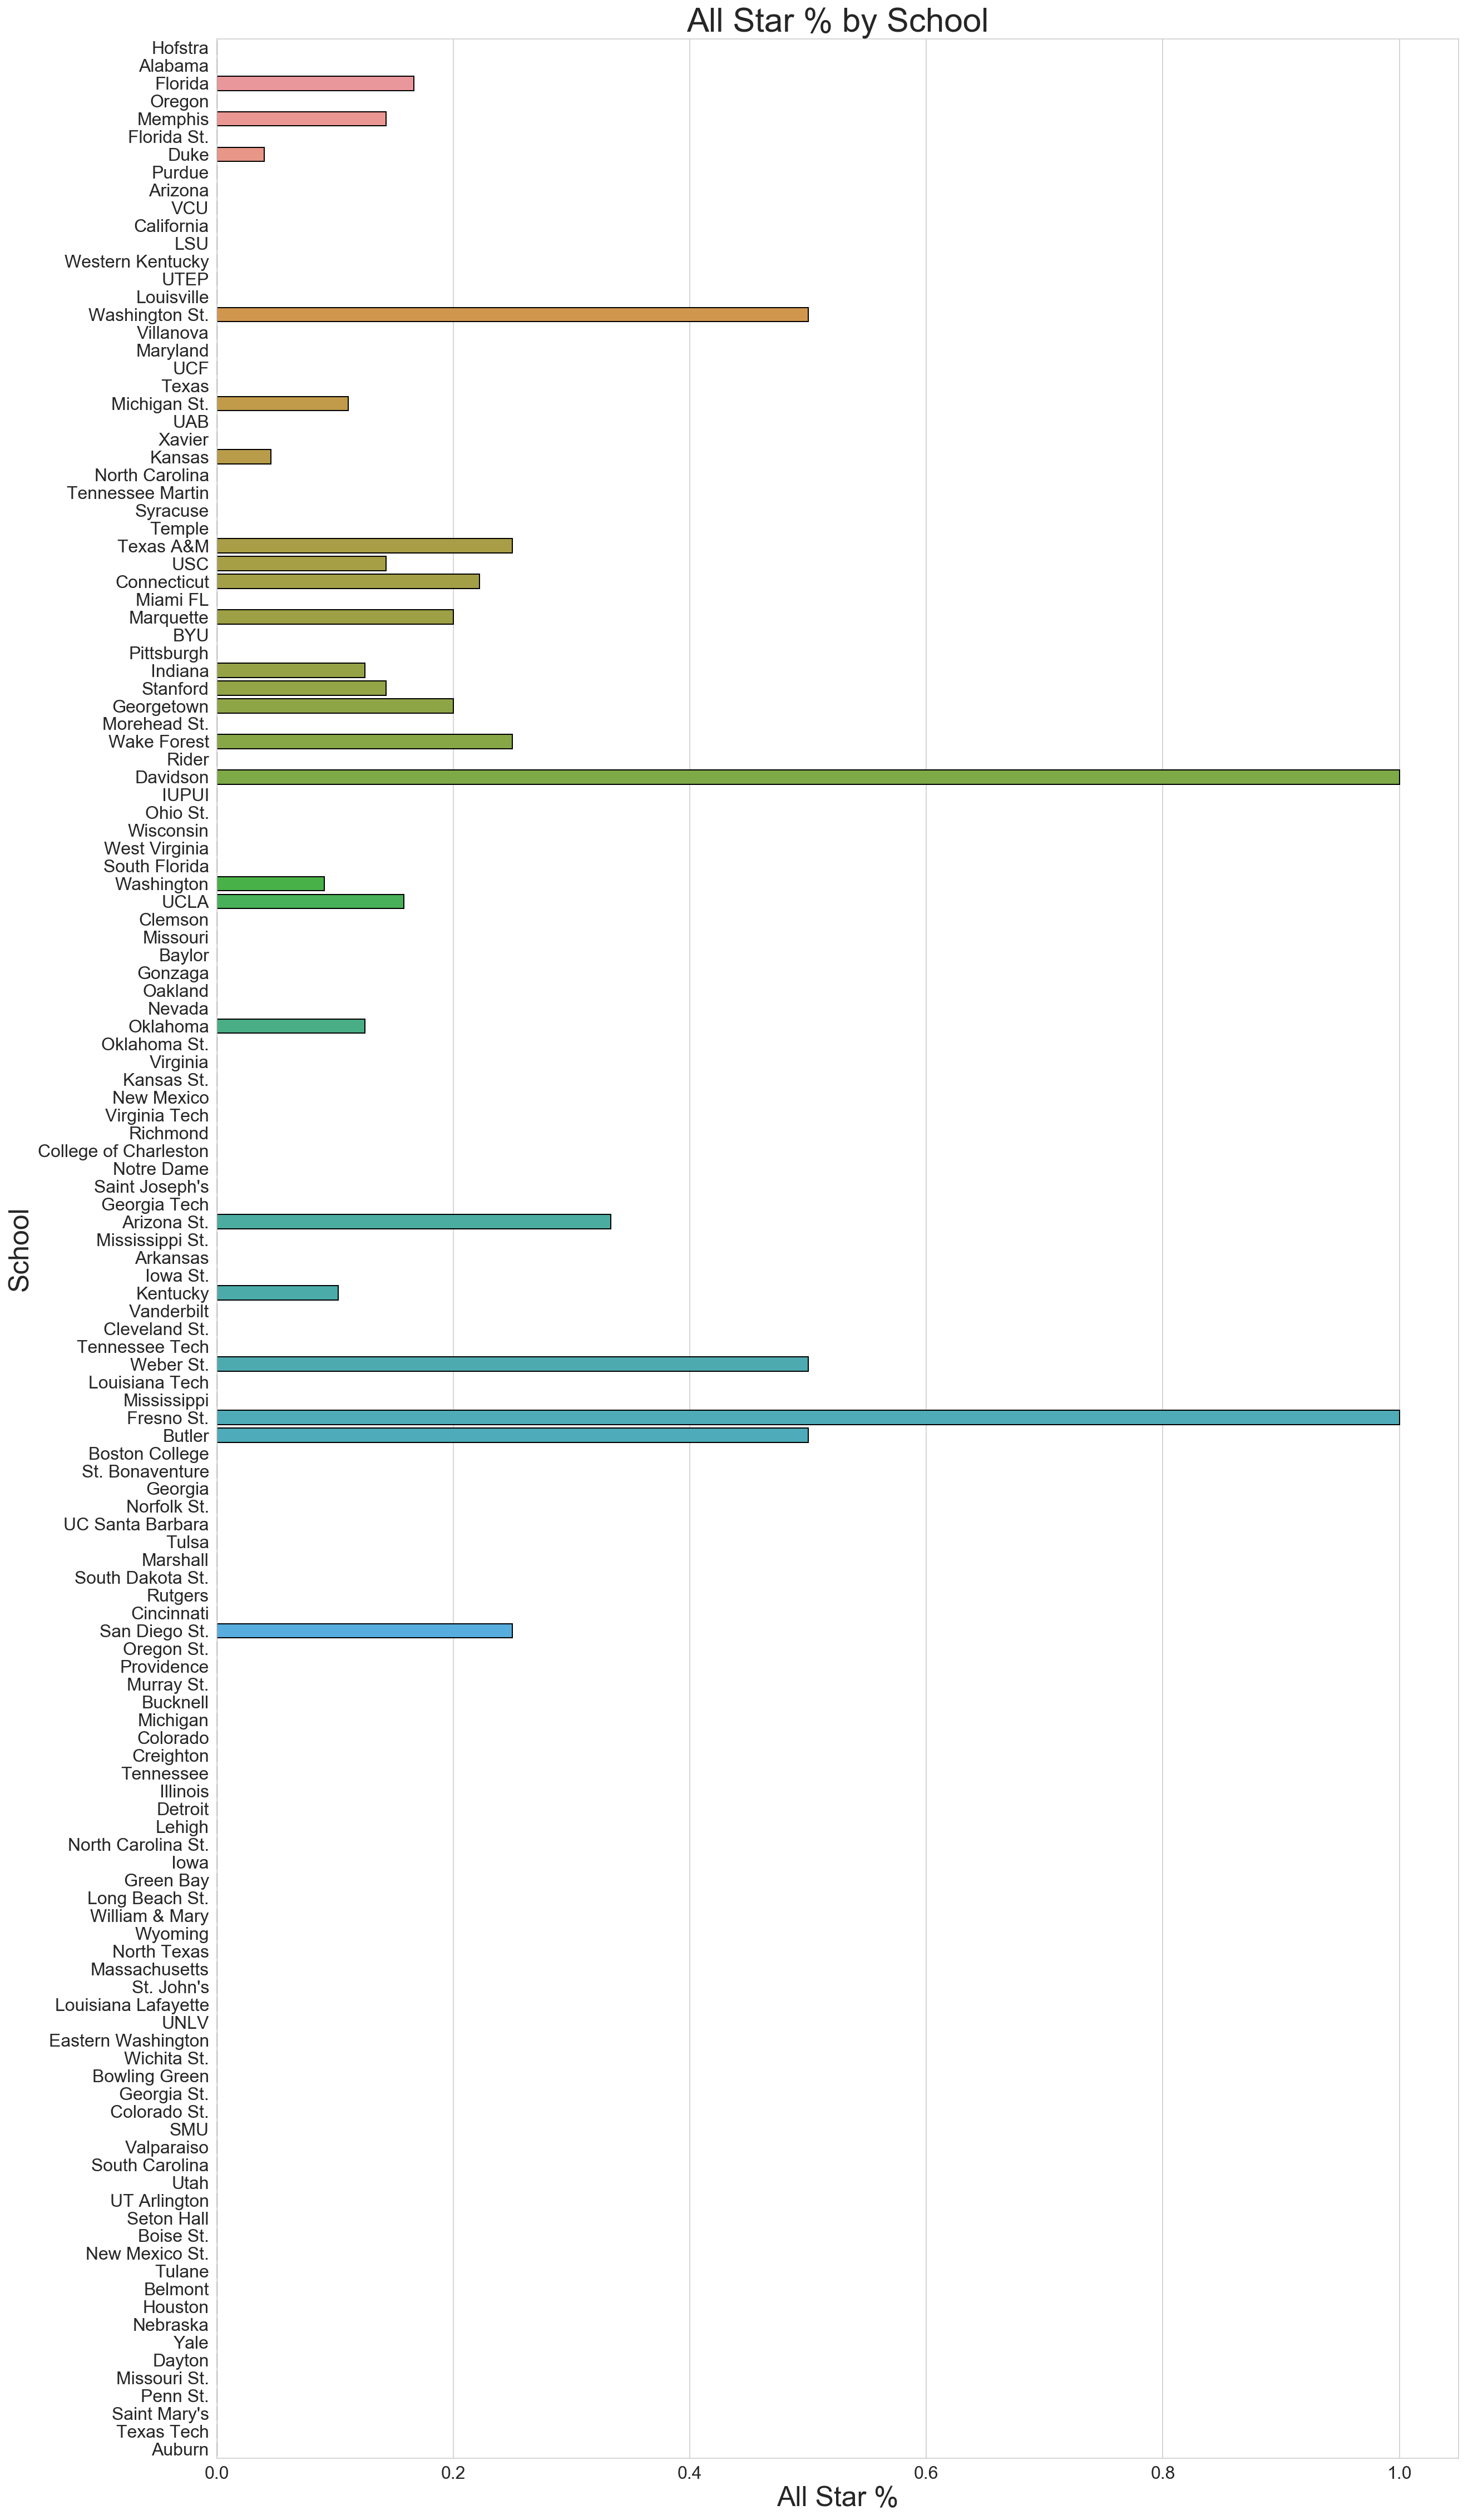

In [87]:
# All-Star % by School
plt.figure(figsize= (20, 40))
sns.barplot(y = 'school', x= 'all_star', data = single_season_df, orient = 'h', ci = None, edgecolor = 'black')
plt.title('All Star % by School', size = 30)
plt.xlabel('All Star %', size = 25)
plt.ylabel('School', size = 25)
plt.xticks(size = 16)
plt.yticks(size = 16);

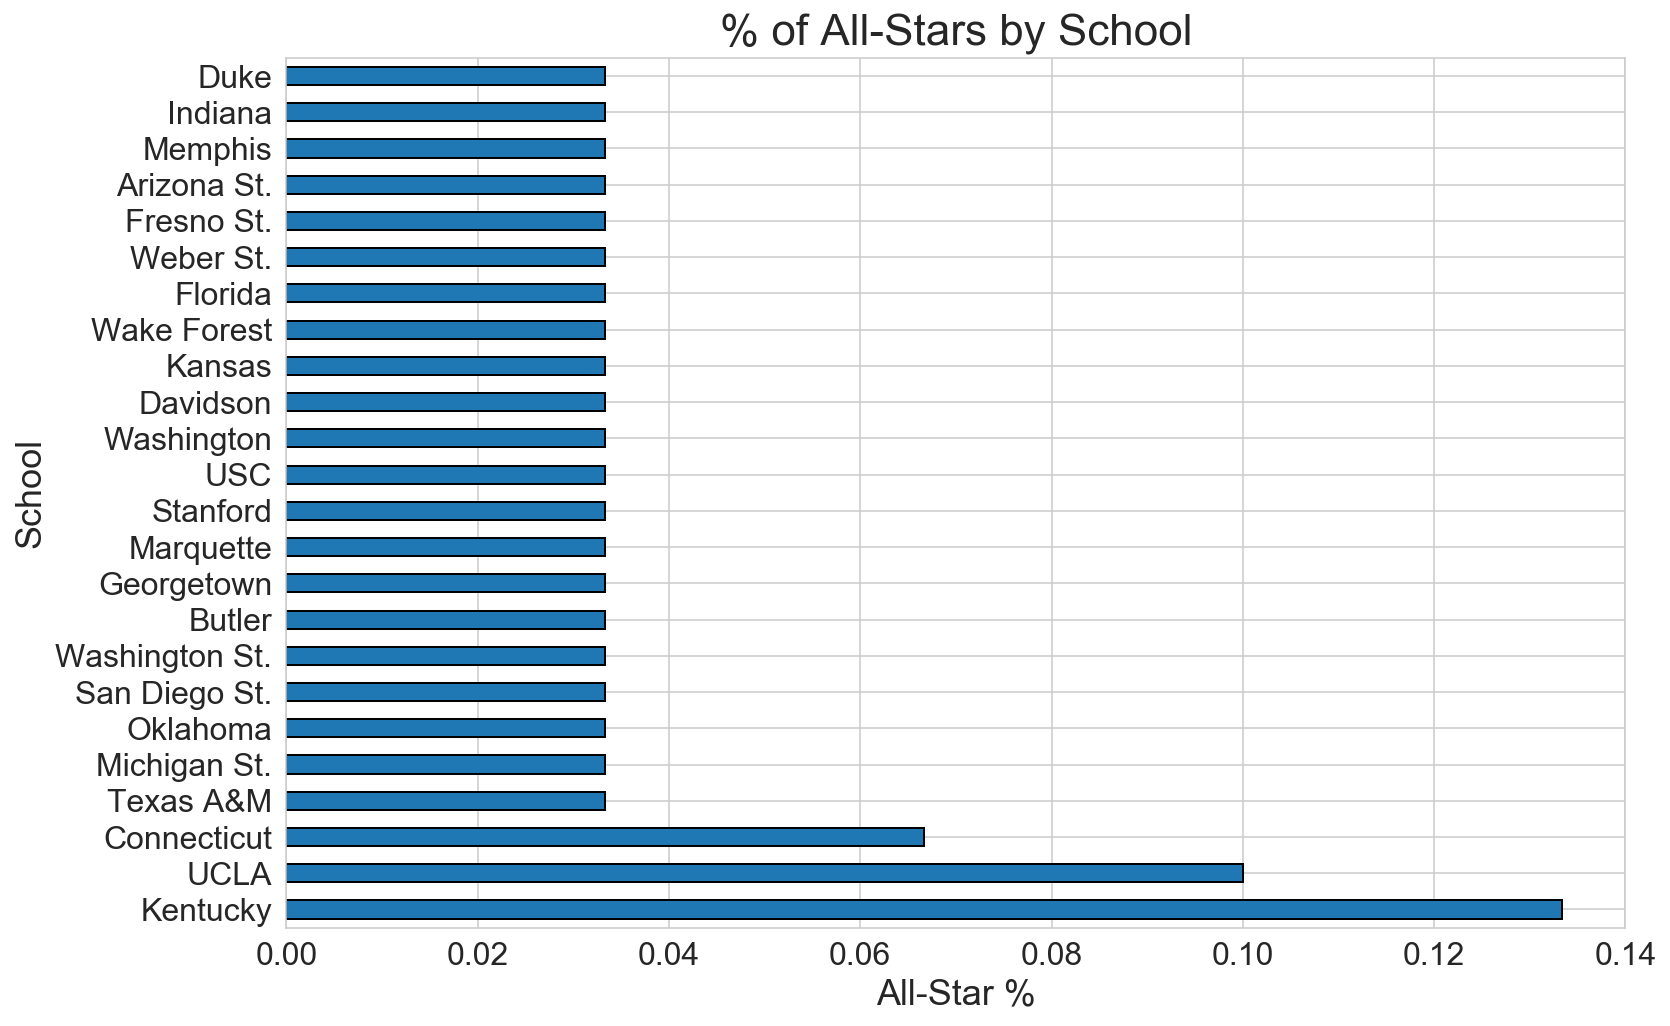

In [88]:
#Plotting where current All-Stars when to College
plt.figure(figsize = (12,8))
single_season_df[single_season_df['all_star'] == 1]['school'].value_counts(normalize = True).plot(kind = 'barh',
                                                                                                 edgecolor = 'black')
plt.title('% of All-Stars by School', size = 22)
plt.xlabel('All-Star %', size = 18)
plt.ylabel("School", size = 18)
plt.xticks(rotation = 0, size = 16)
plt.yticks(size = 16);

Due to so many schools not having any all stars, we are going to remove that column from the dataset. We will be able to get more information from the conferences column. It is interesting to note though that Kentucky has had the most players become All-Stars that have been drafted over the last 10 years. 

In [89]:
single_season_df.conference.value_counts()

ACC          112
Non_major    110
SEC           87
B12           73
P12           57
BE            57
B10           56
P10           29
Name: conference, dtype: int64

The ACC conference has had the most players drafted since 2008 followed by the sum of all the non-major conferences. PAC10 has by the fewest but this is partially due to the conference expanding to the PAC12 in 2011.

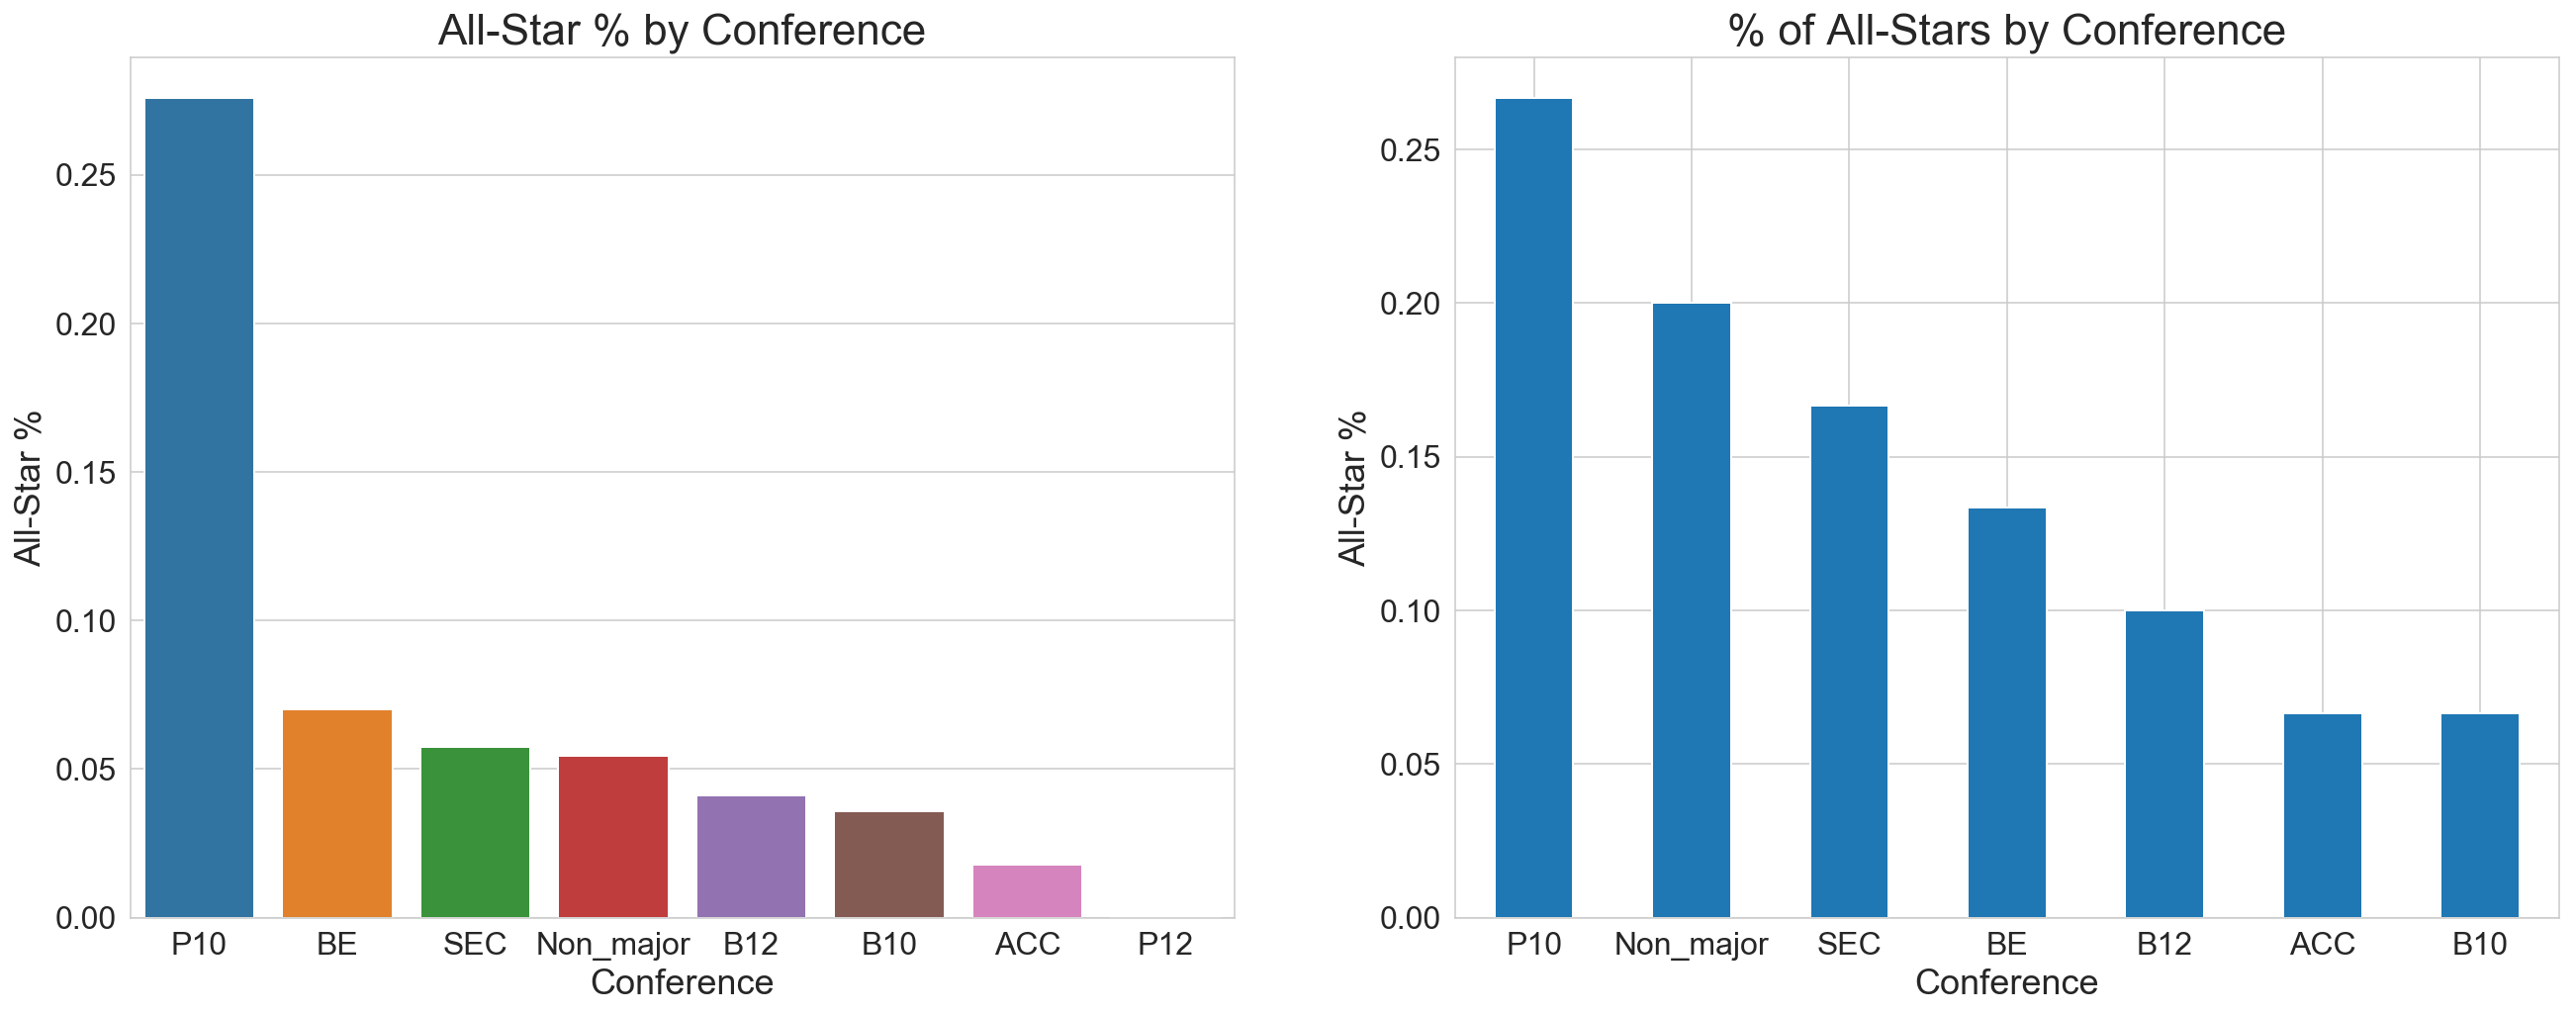

In [90]:
# Graphs showing All-Star % by # of Years Played in College
plt.figure(figsize= (22, 8))

plt.subplot(1,2,1)
sns.barplot(x = 'conference', y= 'all_star', data = single_season_df, ci = None, 
            order = ['P10', 'BE', 'SEC', 'Non_major', 'B12', 'B10', 'ACC', 'P12'])
plt.xlabel('Conference', size = 18)
plt.ylabel('All-Star %', size = 18)
plt.title('All-Star % by Conference', size = 22)
plt.xticks(size = 16)
plt.yticks(size = 16)

plt.subplot(1,2,2)
single_season_df[single_season_df['all_star'] == 1]['conference'].value_counts(normalize = True).plot(kind = 'bar')
plt.title('% of All-Stars by Conference', size = 22)
plt.xlabel('Conference', size = 18)
plt.ylabel("All-Star %", size = 18)
plt.xticks(rotation = 0, size = 16)
plt.yticks(size = 16);

The percentage of players that have become All-Stars from each conference is pretty surprising. We did not expect the non_major conferences to have a higher percentage of All-Stars than the ACC which has historically been the best conference in college basketball. Despite having by far the fewest draft picks, the PAC10 had the largest All-Star % by approximately 20%. When a PAC10 player was drafted, they were more often than not a quality player. The PAC12 has not had any All-Stars since the conference was formed from the PAC10 in 2011. It is also interesting to note that close to 50% of the All-Stars drafted since 2008 played in the PAC10 or a Non-major conference. Playing in the best conference in college does not necessarily translate to being successful at the professional level. 

In [91]:
#All-Star % by conference
single_season_df.groupby('conference')['all_star'].mean()

conference
ACC          0.017857
B10          0.035714
B12          0.041096
BE           0.070175
Non_major    0.054545
P10          0.275862
P12          0.000000
SEC          0.057471
Name: all_star, dtype: float64

In [92]:
# What conference did current All-Stars play in college
single_season_df[single_season_df['all_star'] == 1]['conference'].value_counts(normalize = True)

P10          0.266667
Non_major    0.200000
SEC          0.166667
BE           0.133333
B12          0.100000
ACC          0.066667
B10          0.066667
Name: conference, dtype: float64

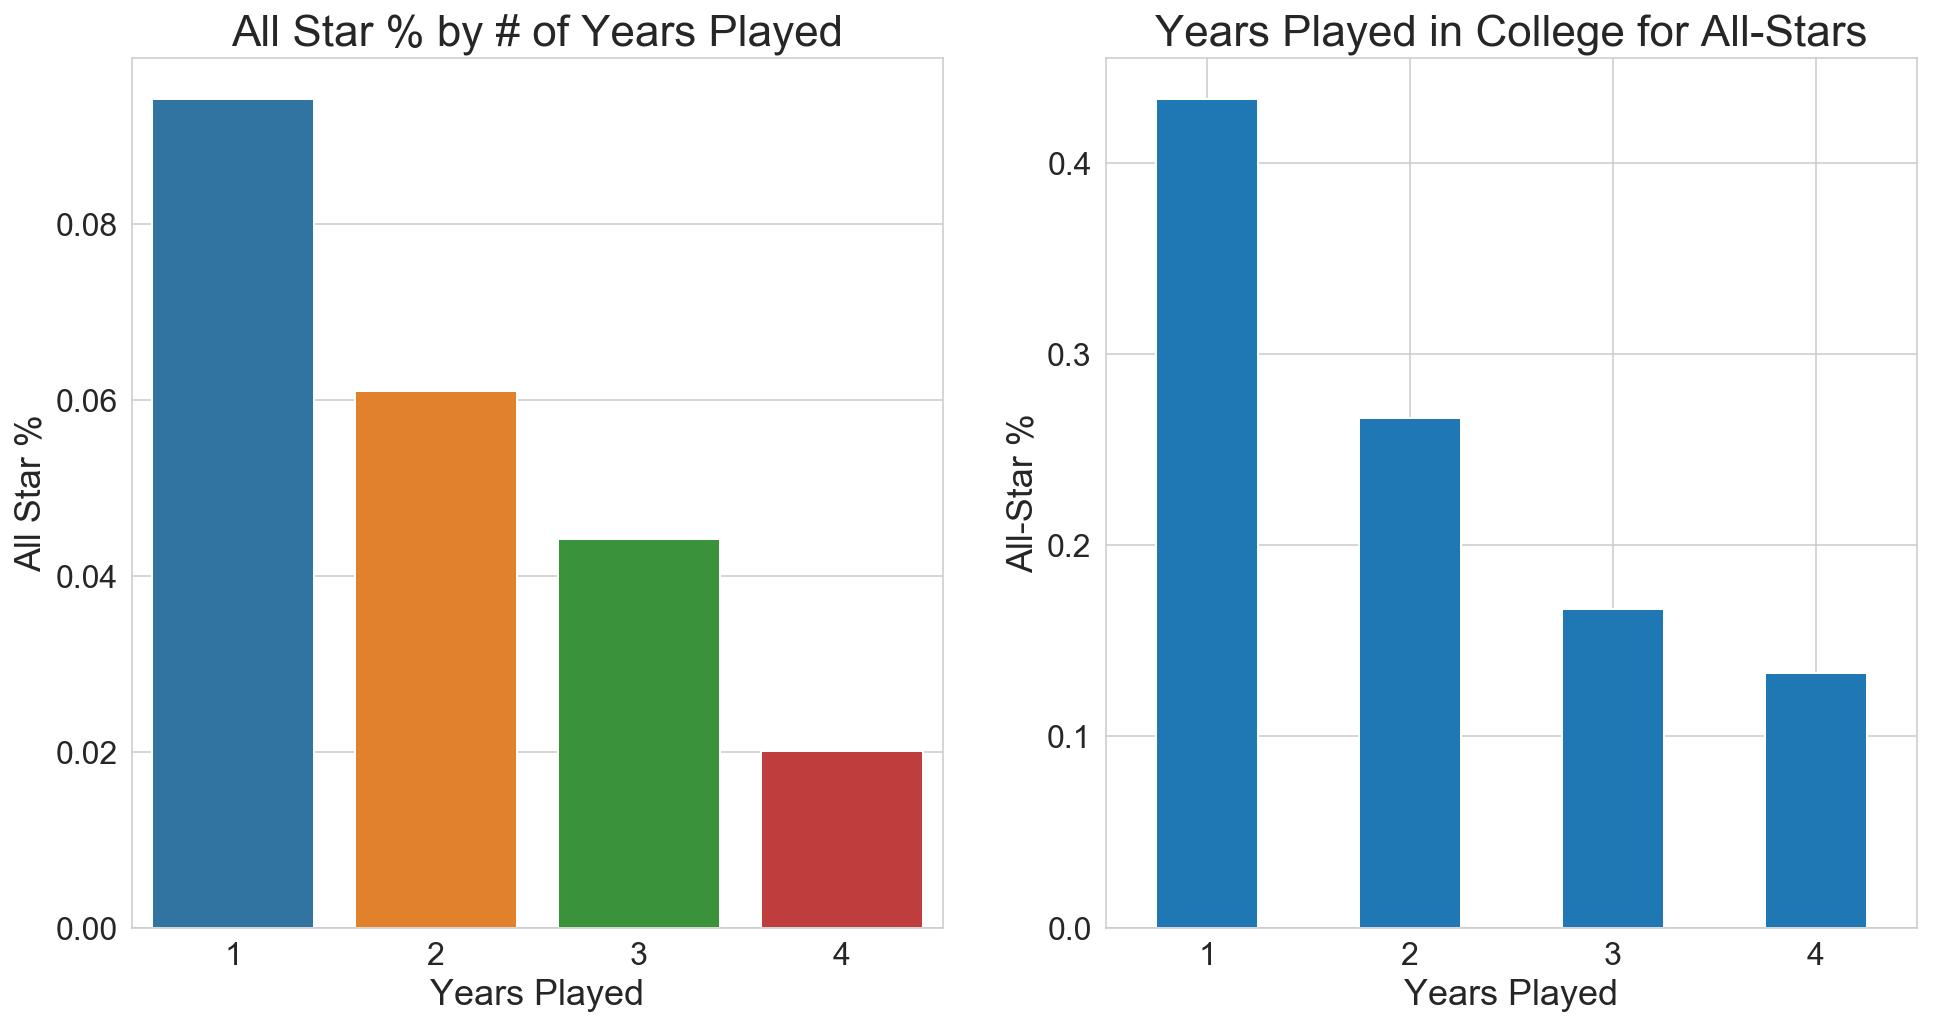

In [93]:
# Graphs showing All-Star % by # of Years Played in College
plt.figure(figsize= (16, 8))

plt.subplot(1,2,1)
sns.barplot(x = 'yr', y= 'all_star', data = single_season_df, ci = None)
plt.xlabel('Years Played', size = 18)
plt.ylabel('All Star %', size = 18)
plt.title('All Star % by # of Years Played', size = 22)
plt.xticks(size = 16)
plt.yticks(size = 16)

plt.subplot(1,2,2)
single_season_df[single_season_df['all_star'] == 1]['yr'].value_counts(normalize = True).plot(kind = 'bar')
plt.title('Years Played in College for All-Stars', size = 22)
plt.xlabel('Years Played', size = 18)
plt.ylabel("All-Star %", size = 18)
plt.xticks(rotation = 0, size = 16)
plt.yticks(size = 16);

The graph on the left shows a breakdown of the percentage of college players drafted that became All-Stars for each college year. Both Freshmen and Sophomores have a higher overall rate than the average for all players drafted (approx. 5%). This shows that the number of years of experience playing in college does not necessarily mean that a player will become successful in the NBA. Players that leave after 1 or 2 years in school are usually more prepared and do not need additional development at the college level. They also tend to be higher rated recruits coming out of high school which has been a big determinant of future draft position which is correlated with becoming an All-Star.

The graph on the right shows what percentage of all-stars left college as a Freshman, Sophomore, Junior or Senior. These results are in line with the previous graph. The majority of All-Stars in the last 10 years left college after only playing 1 or 2 years.

In [94]:
# All-Star % by years played
single_season_df.groupby('yr')['all_star'].mean()

yr
1    0.094203
2    0.061069
3    0.044248
4    0.020101
Name: all_star, dtype: float64

In [95]:
# How many years did current All-Stars play on average in college
single_season_df[single_season_df['all_star'] == 1]['yr'].value_counts(normalize = True)

1    0.433333
2    0.266667
3    0.166667
4    0.133333
Name: yr, dtype: float64

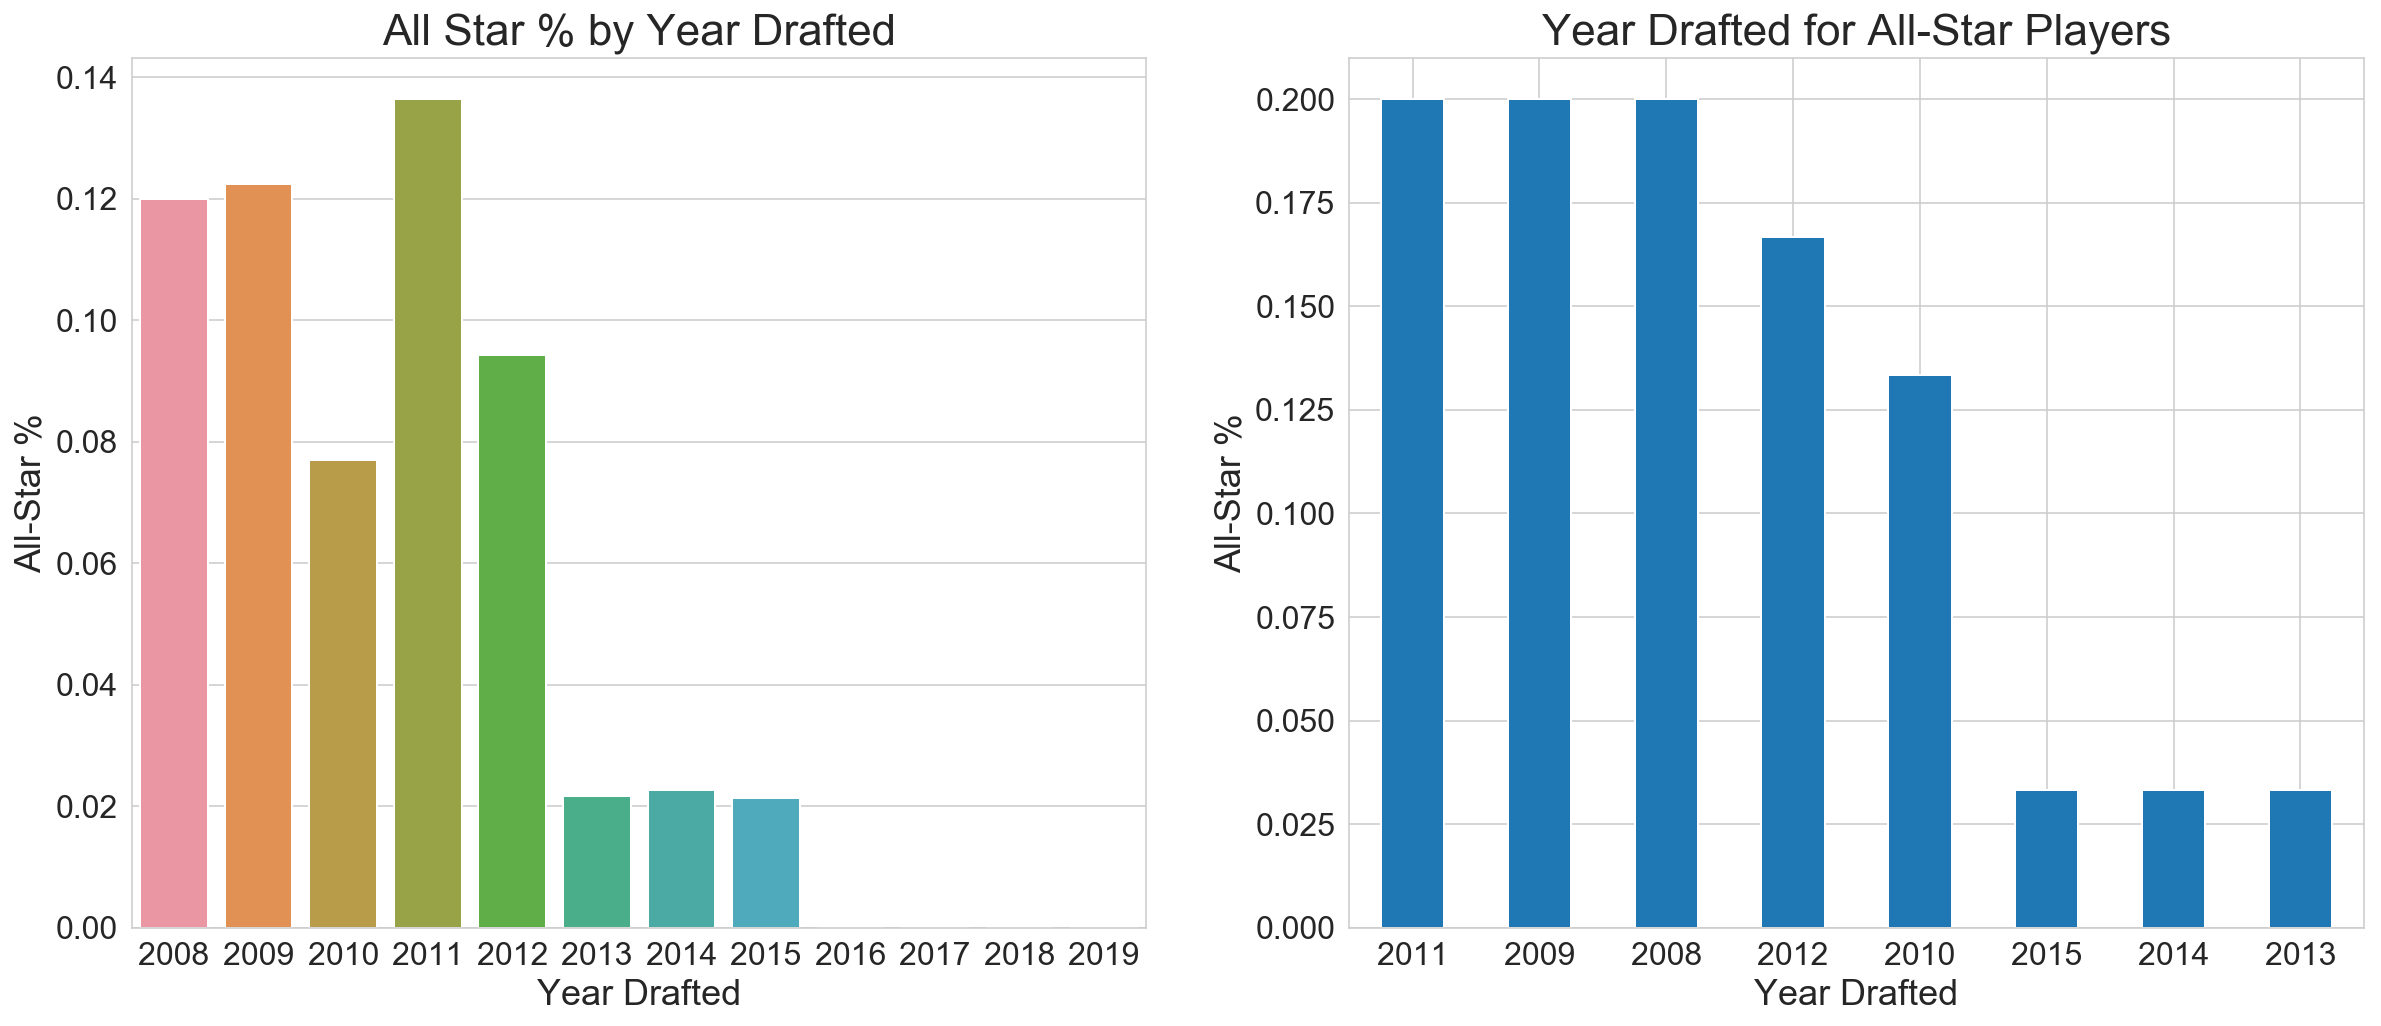

In [96]:
#Plotting All-Star % by Year-Drafted
plt.figure(figsize= (20, 8))

plt.subplot(1,2,1)


sns.barplot(x = 'year', y= 'all_star', data = single_season_df, ci = None)
plt.xlabel('Year Drafted', size = 18)
plt.ylabel('All-Star %', size = 18)
plt.title('All Star % by Year Drafted', size = 22)
plt.xticks(size = 16)
plt.yticks(size = 16)

plt.subplot(1,2,2)
single_season_df[single_season_df['all_star'] == 1]['year'].value_counts(normalize = True).plot(kind = 'bar')
plt.title('Year Drafted for All-Star Players', size = 22)
plt.xlabel('Year Drafted', size = 18)
plt.ylabel("All-Star %", size = 18)
plt.xticks(rotation = 0, size = 16)
plt.yticks(size = 16);

No player that was drafted in the last 3 years has made an All-Star game. This shows how difficult it is to make the team and that in the NBA it is hard to come in and be successful right away. It takes a lot of growth and development.

In [97]:
# % of players to make All-Star game by year drafted
single_season_df.groupby('year')['all_star'].mean()

year
2008    0.120000
2009    0.122449
2010    0.076923
2011    0.136364
2012    0.094340
2013    0.021739
2014    0.022727
2015    0.021277
2016    0.000000
2017    0.000000
2018    0.000000
2019    0.000000
Name: all_star, dtype: float64

In [98]:
# When current All-Stars were drafted
single_season_df[single_season_df['all_star'] == 1]['year'].value_counts(normalize = True)

2011    0.200000
2009    0.200000
2008    0.200000
2012    0.166667
2010    0.133333
2015    0.033333
2014    0.033333
2013    0.033333
Name: year, dtype: float64

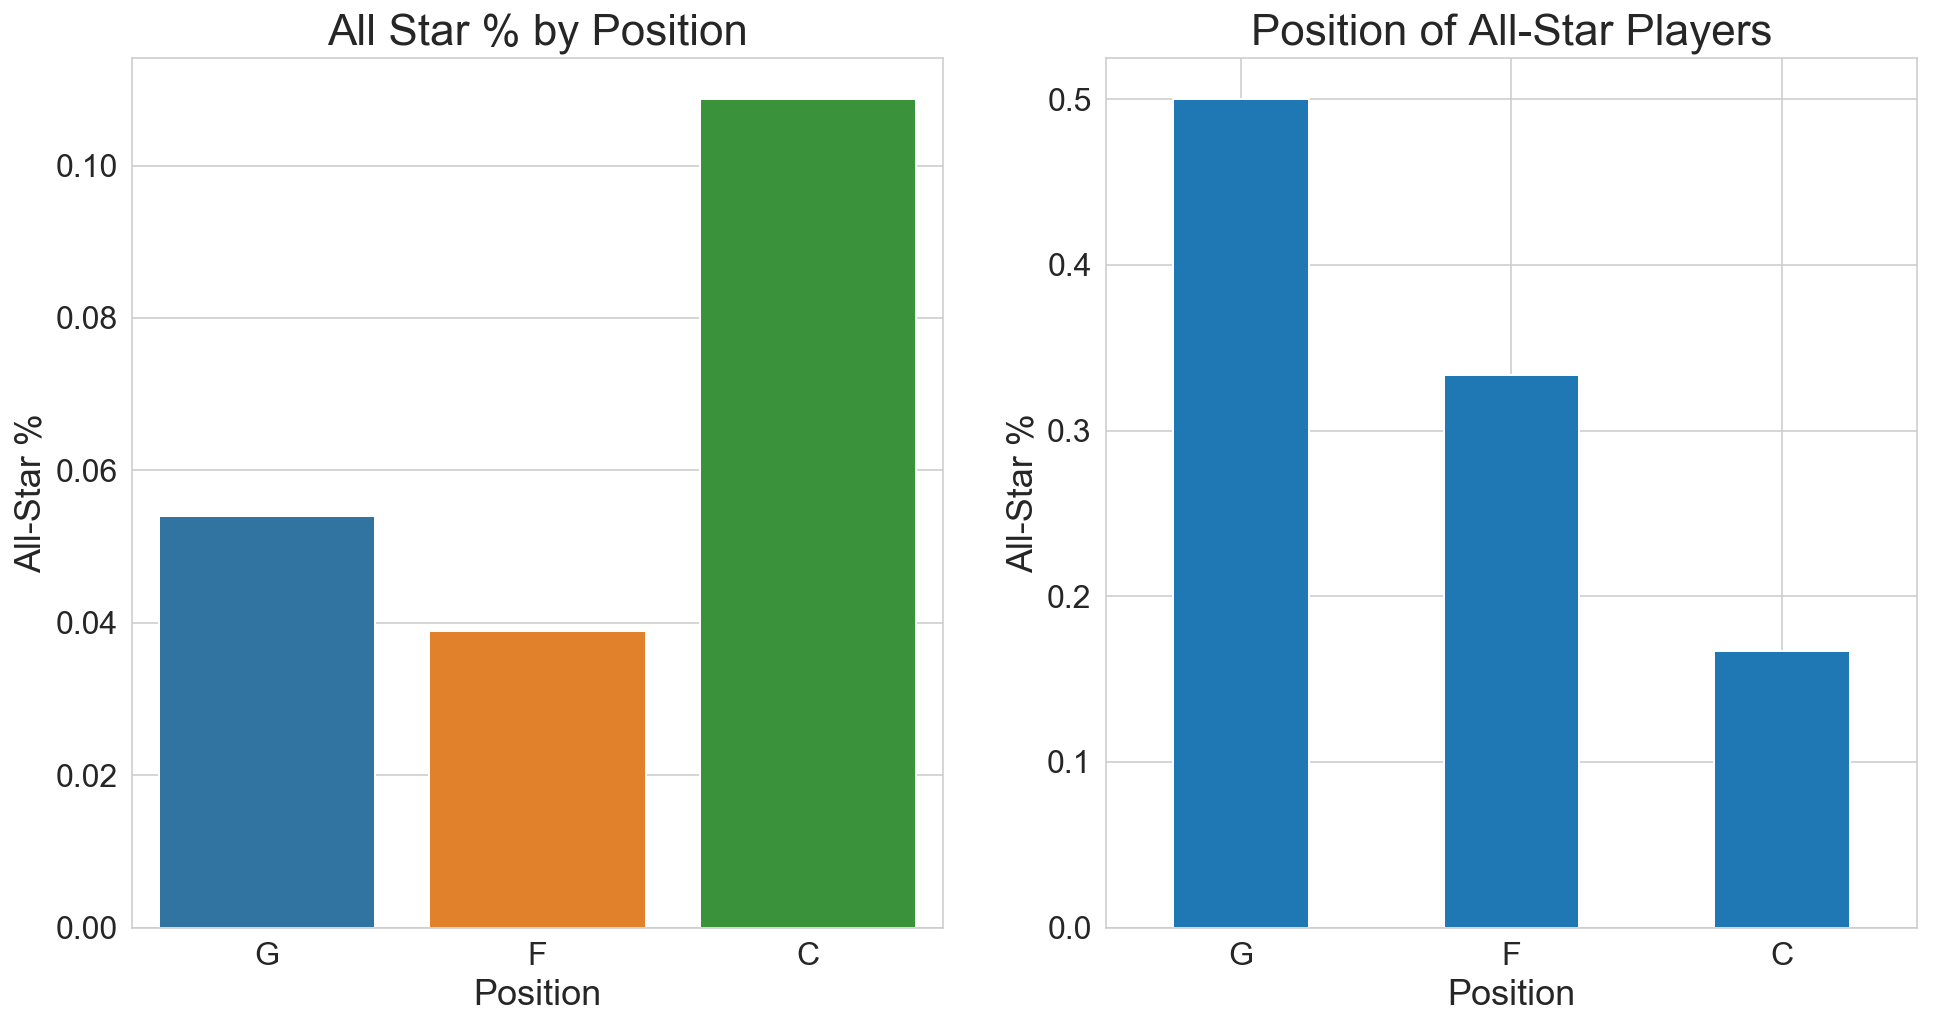

In [99]:
#plotting All-Star % by Position
plt.figure(figsize= (16, 8))

plt.subplot(1,2,1)

sns.barplot(x = 'Pos', y= 'all_star', data = single_season_df, ci = None)
plt.xlabel('Position', size = 18)
plt.ylabel('All-Star %', size = 18)
plt.title('All Star % by Position', size = 22)
plt.xticks(size = 16)
plt.yticks(size = 16)

plt.subplot(1,2,2)
single_season_df[single_season_df['all_star'] == 1]['Pos'].value_counts(normalize = True).plot(kind = 'bar')
plt.title('Position of All-Star Players', size = 22)
plt.xlabel('Position', size = 18)
plt.ylabel("All-Star %", size = 18)
plt.xticks(rotation = 0, size = 16)
plt.yticks(size = 16);

- G: Guard
- F: Forward
- C: Center

Centers had the highest rate of becoming an All-Star of the players drafted since 2008 at approximately 11%. Forwards were least likely at a rate of approximately 4%. It is important to note that there have been far fewer centers enter the draft than either guards or forwards. Despite this, the positive hit rate for centers is higher than the other positions. Of the players that have made an All-Star game, 83% have been guards and forwards. This makes sense since historically there have been two guards, two forwards and one center in a starting lineup. However, over the last several years this standard lineup has changed as the game has been more focused on shooting and playing more athletic smaller players.

In [100]:
single_season_df['Pos'].value_counts()

G    278
F    257
C     46
Name: Pos, dtype: int64

In [101]:
single_season_df.groupby('Pos')['all_star'].mean()

Pos
C    0.108696
F    0.038911
G    0.053957
Name: all_star, dtype: float64

In [102]:
single_season_df[single_season_df['all_star'] == 1]['Pos'].value_counts(normalize = True)

G    0.500000
F    0.333333
C    0.166667
Name: Pos, dtype: float64

In [103]:
single_season_df.groupby('all_star').mean().T

all_star,0,1
GP,33.600726,34.266667
Min_per,73.923775,73.106667
ORtg,112.876044,114.333333
usg,24.595826,26.550000
eFG,54.200726,54.766667
TS_per,57.793503,58.908000
ORB_per,6.954446,8.173333
DRB_per,16.401452,17.406667
AST_per,15.772958,19.240000
TO_per,16.383485,17.636667


Not many of the stats have large discrepancies when categorized by All-Star vs non-All-Stars. All-Stars take and make more free throws. This could be because better college players tend to be more aggressive which is correlated with getting fouled more often. All-Stars also have a higher porpag and are drafted significantly earlier. This makes sense since the players drafted earliest are supposed to be the best. It was also suprising to us that the points per game for All-Stars were only slightly higher (approx. 1 point) than non-All-Stars. 


In [104]:
single_season_df.groupby('all_star')['ht'].describe().T

all_star,0,1
count,551.000000,30.000000
mean,78.885662,78.433333
std,3.155312,4.107884
min,69.000000,69.000000
25%,77.000000,75.000000
50%,79.000000,78.000000
75%,81.000000,82.000000
max,87.000000,86.000000


In [105]:
single_season_df[(single_season_df['all_star'] == 1) & (single_season_df['ht'] == 86)]

,player_name,school,conference,GP,Min_per,ORtg,usg,eFG,TS_per,ORB_per,DRB_per,AST_per,TO_per,FTM,FTA,FT_per,twoPM,twoPA,twoP_per,TPM,TPA,TP_per,blk_per,stl_per,ftr,yr,ht,porpag,adjoe,pfr,year,pid,ast/tov,pick,drtg,adrtg,dporpag,stops,bpm,obpm,dbpm,gbpm,mp,ogbpm,dgbpm,all_star,total_points,PPG,Pos
98,Roy Hibbert,Georgetown,BE,34,65.3,119.2,25.6,61.4,62.64,11.3,17.0,16.6,15.7,93,144,0.646,176,291,0.605,3,3,1.0,9.7,1.3,49.0,4,86,4.4024,133.308,4.1,2008,3031,1.105219,17.0,88.6449,83.9796,3.87887,183.785,11.7728,4.74373,7.02904,11.109,26.3235,6.852,4.257,1,454,13.35,C


In [106]:
single_season_df[(single_season_df['all_star'] == 1) & (single_season_df['ht'] == 69)]

,player_name,school,conference,GP,Min_per,ORtg,usg,eFG,TS_per,ORB_per,DRB_per,AST_per,TO_per,FTM,FTA,FT_per,twoPM,twoPA,twoP_per,TPM,TPA,TP_per,blk_per,stl_per,ftr,yr,ht,porpag,adjoe,pfr,year,pid,ast/tov,pick,drtg,adrtg,dporpag,stops,bpm,obpm,dbpm,gbpm,mp,ogbpm,dgbpm,all_star,total_points,PPG,Pos
163,Isaiah Thomas,Washington,P10,35,79.1,114.3,27.2,51.7,56.25,2.5,9.5,32.7,19.0,151,210,0.719,128,250,0.512,60,172,0.349,0.2,2.3,49.8,3,69,5.04539,130.894,2.7,2011,8712,2.048092,60.0,99.5797,94.9239,3.51267,197.365,6.45543,6.25357,0.201859,7.288,31.8571,5.93,1.358,1,587,16.77,G


The shortest player to make an All-Star team is only 5 foot 9 inches (Isaiah Thomas) and the tallest person is 7 foot 2 inches (Roy Hibbert).  The average All-Star is 6 foot 6 inches.

In [107]:
single_season_df.groupby('all_star')['GP'].describe().T

all_star,0,1
count,551.000000,30.000000
mean,33.600726,34.266667
std,4.752446,5.638130
min,3.000000,11.000000
25%,32.000000,34.000000
50%,34.000000,35.000000
75%,36.000000,37.000000
max,40.000000,41.000000


In [108]:
single_season_df[(single_season_df['all_star'] == 1) & (single_season_df['GP'] == 11)]

,player_name,school,conference,GP,Min_per,ORtg,usg,eFG,TS_per,ORB_per,DRB_per,AST_per,TO_per,FTM,FTA,FT_per,twoPM,twoPA,twoP_per,TPM,TPA,TP_per,blk_per,stl_per,ftr,yr,ht,porpag,adjoe,pfr,year,pid,ast/tov,pick,drtg,adrtg,dporpag,stops,bpm,obpm,dbpm,gbpm,mp,ogbpm,dgbpm,all_star,total_points,PPG,Pos
256,Kyrie Irving,Duke,ACC,11,20.5,130.5,27.2,61.5,69.7,2.3,10.6,29.8,18.6,64,71,0.901,37,65,0.569,18,39,0.462,1.8,3.0,68.3,1,74,6.12884,149.048,3.0,2011,18579,1.740762,1.0,91.7011,87.1588,3.80115,61.4034,12.4609,9.66412,2.79681,13.719,27.5455,9.747,3.972,1,192,17.45,G


In [109]:
single_season_df[(single_season_df['all_star'] == 1) & (single_season_df['GP'] == 41)]

,player_name,school,conference,GP,Min_per,ORtg,usg,eFG,TS_per,ORB_per,DRB_per,AST_per,TO_per,FTM,FTA,FT_per,twoPM,twoPA,twoP_per,TPM,TPA,TP_per,blk_per,stl_per,ftr,yr,ht,porpag,adjoe,pfr,year,pid,ast/tov,pick,drtg,adrtg,dporpag,stops,bpm,obpm,dbpm,gbpm,mp,ogbpm,dgbpm,all_star,total_points,PPG,Pos
169,Kemba Walker,Connecticut,BE,41,92.4,117.8,31.5,47.8,54.3,3.9,11.5,28.0,11.8,258,315,0.819,241,512,0.471,75,227,0.33,0.5,3.1,42.6,3,73,7.49948,143.405,1.5,2011,9075,1.978486,9.0,97.6871,91.1048,4.59401,280.051,11.346,9.31097,2.03508,11.699,37.6341,8.925,2.774,1,965,23.54,G


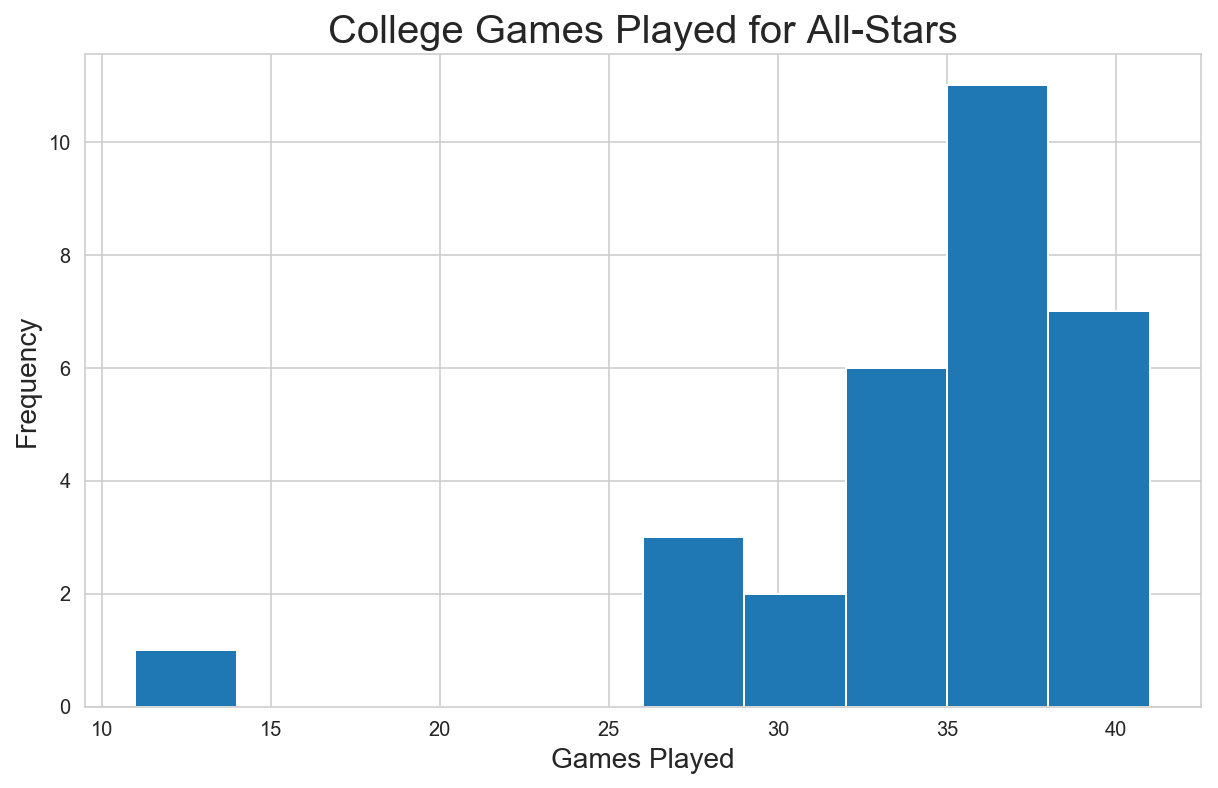

In [110]:
single_season_df[single_season_df['all_star'] ==1].hist(column = 'GP', figsize = (10,6))
plt.title('College Games Played for All-Stars', size = 20)
plt.xlabel('Games Played', size = 14)
plt.ylabel('Frequency', size = 14);
                                  
                                  

The majority of all-stars played between 30 and 40 games in their final college season. Only Kyrie Irving played less than 25 games when he played 11 games in his Freshman year at Duke. Kyrie Irving went on to be the first pick in the draft and has been a perennial All-Star. He is clearly not the norm. The majority of All-Stars played over 35 games in their final season which means they played deep into the NCAA tournament which signifies that the players were on successful teams. It also shows that NBA All-Stars were healthy in college.

In [111]:
#columns to drop for histograms
drop = ['player_name','school', 'conference', 'year', 'pid', 'pick', 'all_star', 'Pos']


In [112]:
#Created a function below to create histograms for many features.
#Code assistance from Andrew Bergman
def make_histograms(df,list_of_columns):
    fig   = plt.figure(figsize = (20, 40))      # Set the size for each plot
    count = 0                                   # The count sets the location for each subplot
    for column in list_of_columns:
        count += 1                              # By adding 1 to the count I can create a new location for the graph
        ax = fig.add_subplot(16, 3, count)
        df.hist(column = column, ax = ax, figsize = (10,12))
        plt.title(column, size = 18); 
    plt.tight_layout();

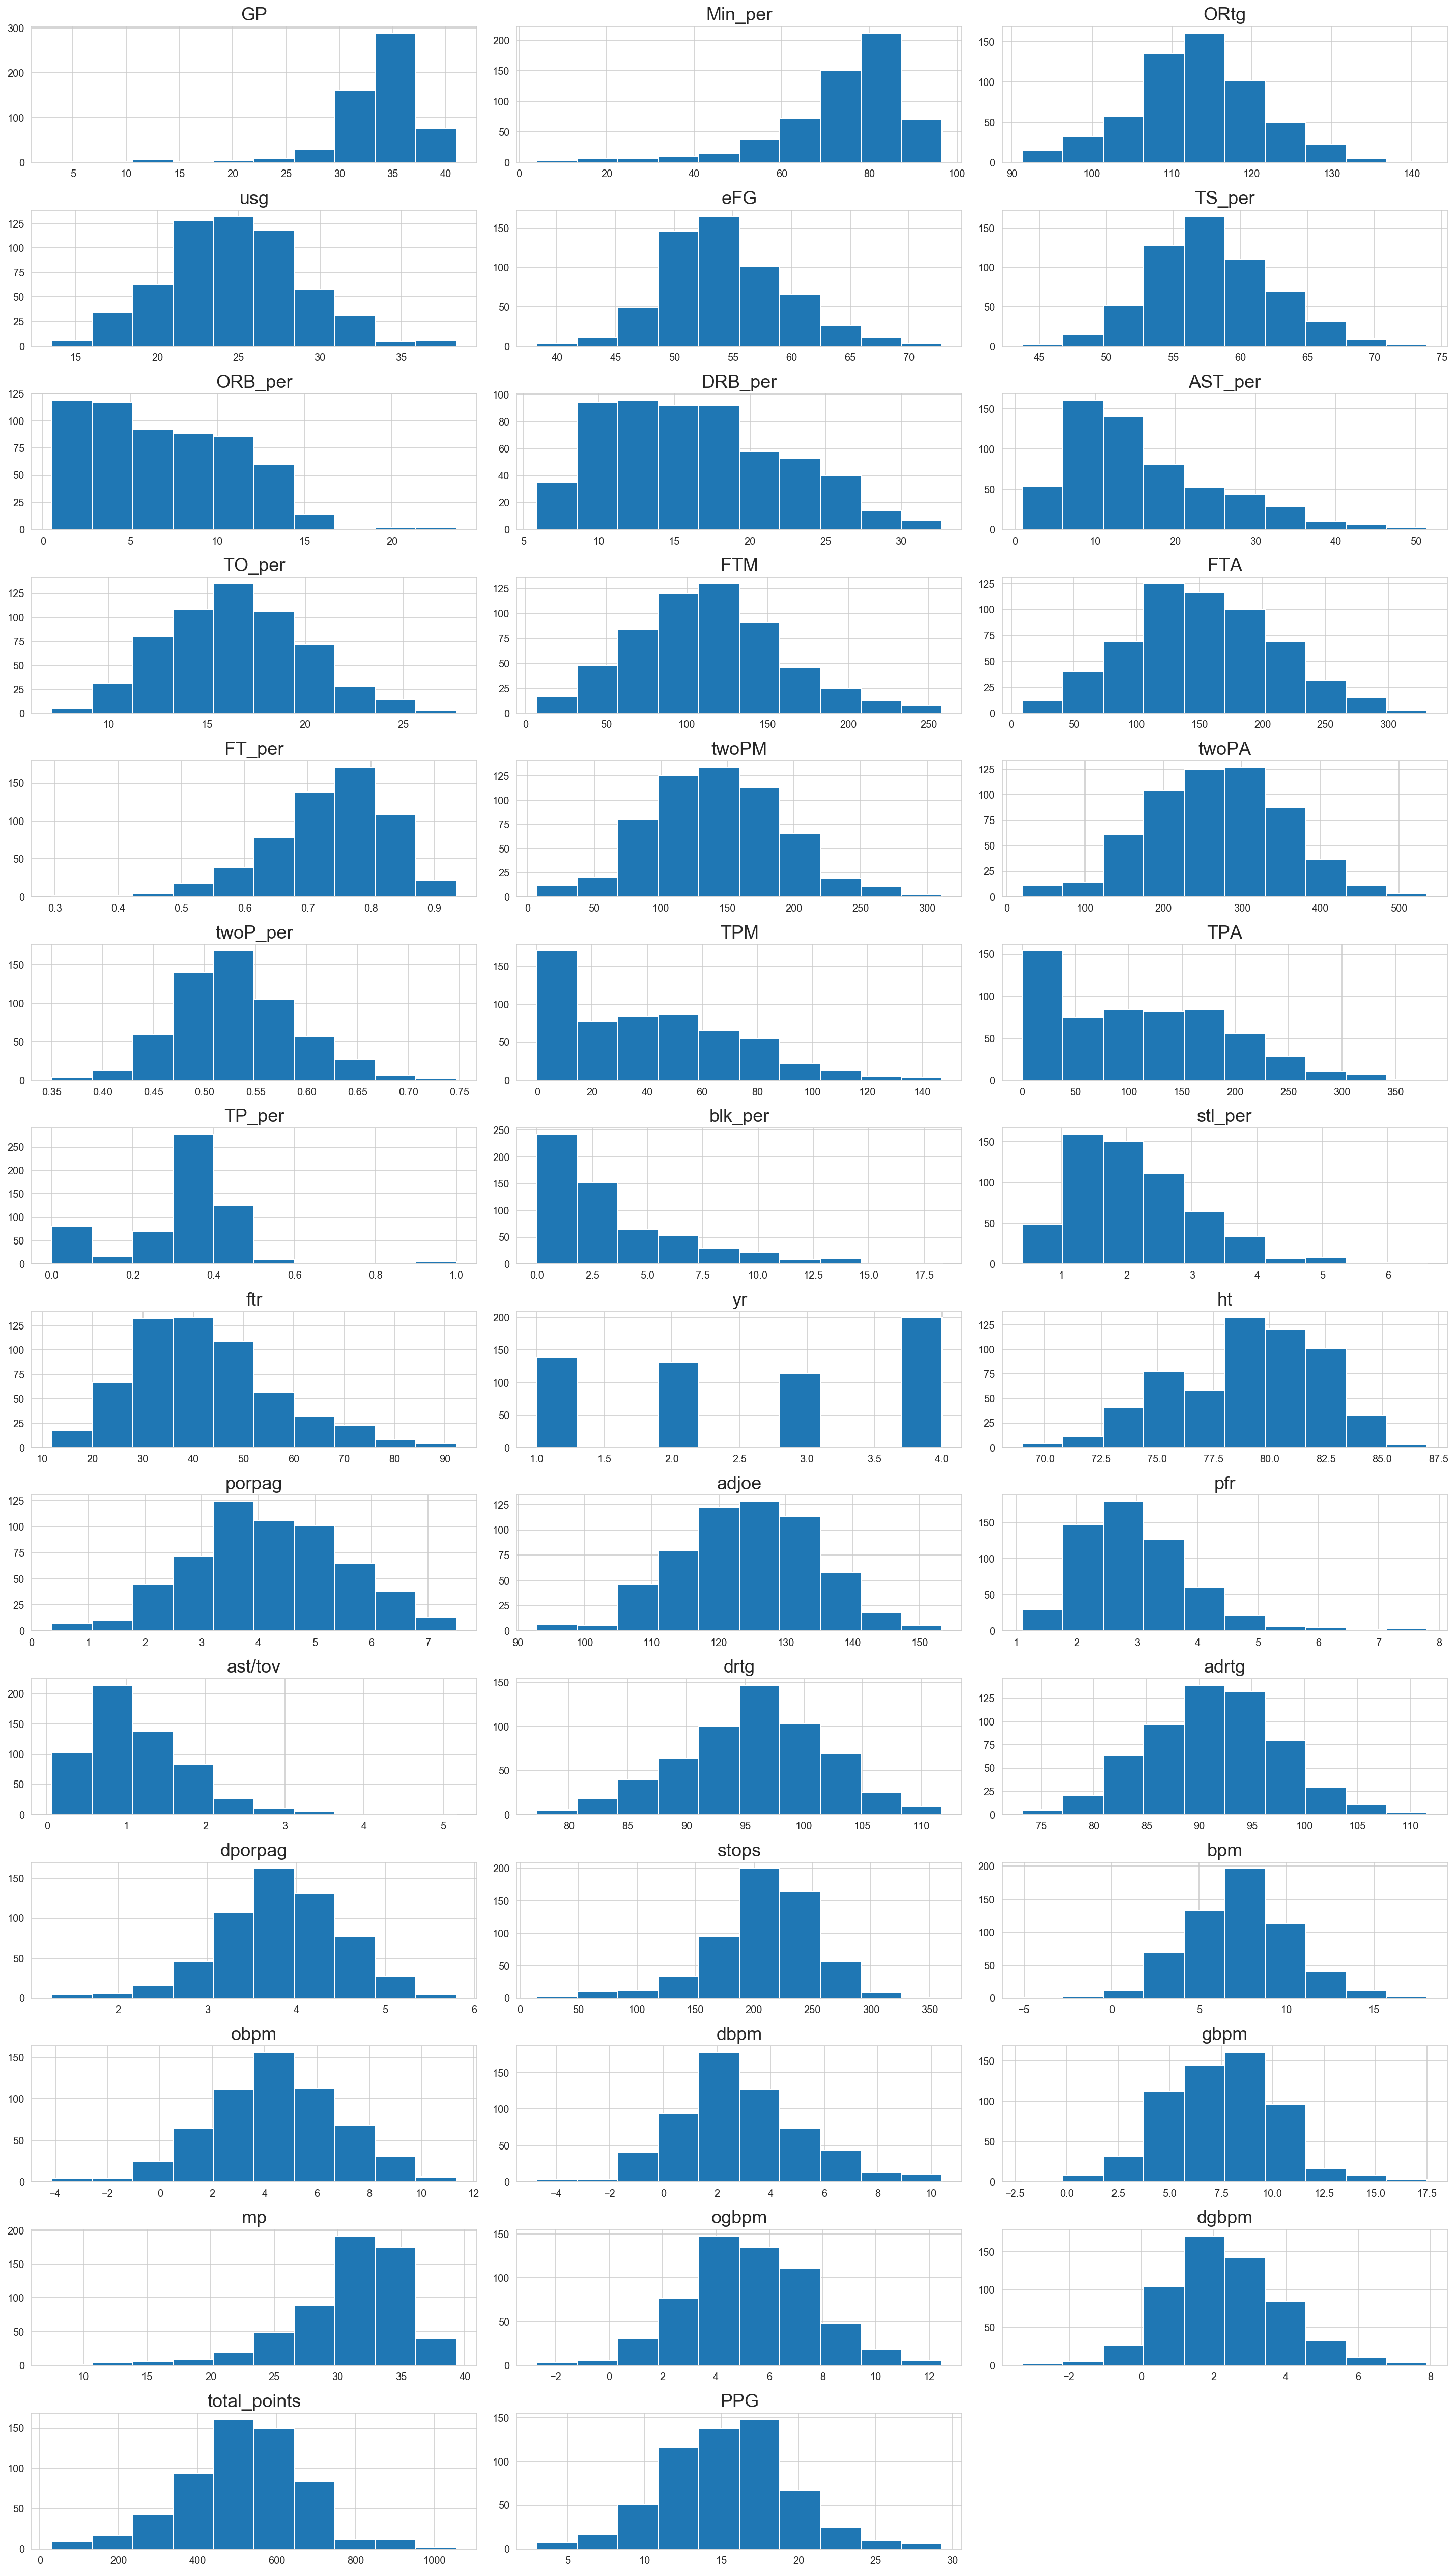

In [113]:
#histograms for numerical columns
make_histograms(single_season_df, single_season_df.drop(columns = drop).columns)

In [114]:
single_season_df.groupby('Pos')['TPM'].mean()

Pos
C     6.586957
F    23.972763
G    60.597122
Name: TPM, dtype: float64

Many of the stats look to be normally distributed. Several features are skewed to the left including games played, minutes percentage and free throw percentage. They are skewed to the left due to several players being outliers and having values far lower than the average. Games played will be low for players that have been injured. Minutes played tend to be low when a player isn't a starter which is rare for a player that gets drafted. The features related to three point shooting are skewed to the right. Not all players shoot a large amount of threes. Guards shoot by far the most three pointers in a season. Approximately 60 threes a season for guards compared to 24 and 6.5 for forwards and centers respectively.

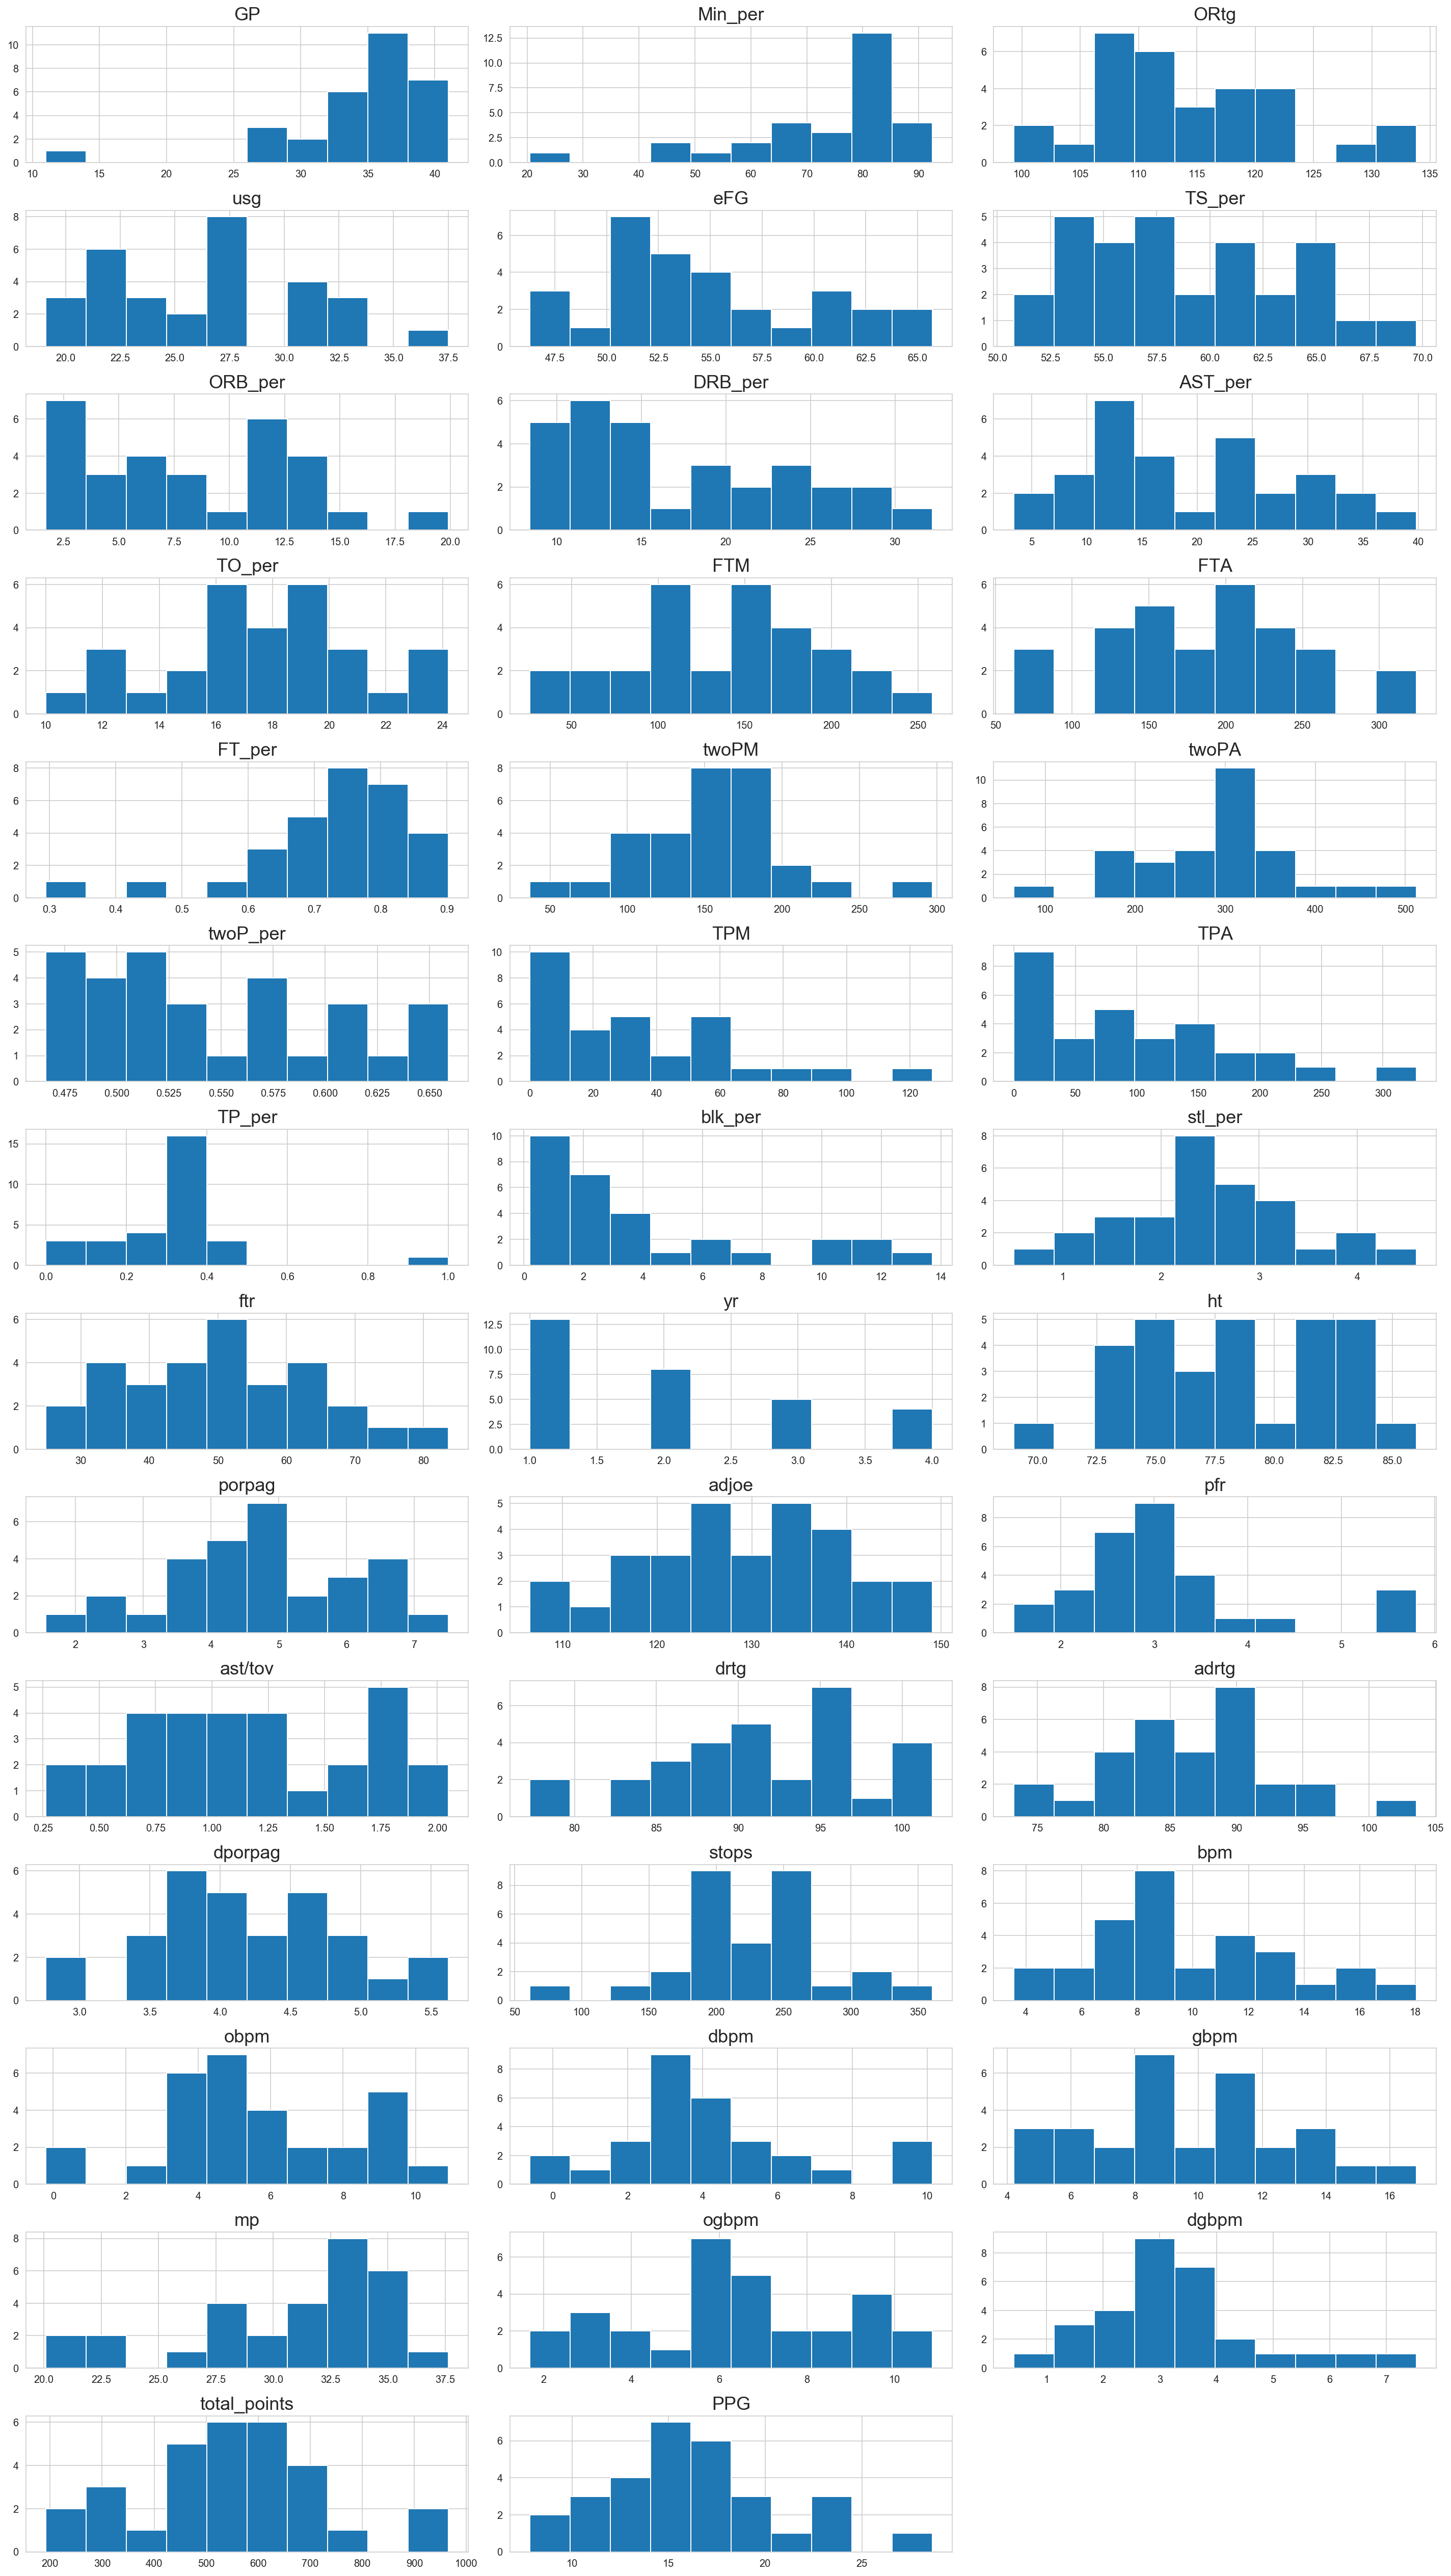

In [115]:
#histograms for numerical columns for only the players that have made an all-star game
make_histograms(single_season_df[single_season_df['all_star'] == 1],single_season_df.drop(columns = drop).columns)



It is easier to outliers when focusing on just the players that have been All-Stars. For example with the games played column, it is easy to see that there was only one player that played less than 25 games in a season and played less than 40% of a teams minutes(both Kyrie Irving). It becomes easier to filter the data when looking at the distributions. For example, we can quickly look at the players with the most free throws attempted (see below) and see that it is a combination of guards and forwards.

In [116]:
single_season_df[(single_season_df['all_star'] == 1) & (single_season_df['GP'] < 25)]

,player_name,school,conference,GP,Min_per,ORtg,usg,eFG,TS_per,ORB_per,DRB_per,AST_per,TO_per,FTM,FTA,FT_per,twoPM,twoPA,twoP_per,TPM,TPA,TP_per,blk_per,stl_per,ftr,yr,ht,porpag,adjoe,pfr,year,pid,ast/tov,pick,drtg,adrtg,dporpag,stops,bpm,obpm,dbpm,gbpm,mp,ogbpm,dgbpm,all_star,total_points,PPG,Pos
256,Kyrie Irving,Duke,ACC,11,20.5,130.5,27.2,61.5,69.7,2.3,10.6,29.8,18.6,64,71,0.901,37,65,0.569,18,39,0.462,1.8,3.0,68.3,1,74,6.12884,149.048,3.0,2011,18579,1.740762,1.0,91.7011,87.1588,3.80115,61.4034,12.4609,9.66412,2.79681,13.719,27.5455,9.747,3.972,1,192,17.45,G


In [117]:
single_season_df[(single_season_df['all_star'] == 1) & (single_season_df['FTA'] > 250)]

,player_name,school,conference,GP,Min_per,ORtg,usg,eFG,TS_per,ORB_per,DRB_per,AST_per,TO_per,FTM,FTA,FT_per,twoPM,twoPA,twoP_per,TPM,TPA,TP_per,blk_per,stl_per,ftr,yr,ht,porpag,adjoe,pfr,year,pid,ast/tov,pick,drtg,adrtg,dporpag,stops,bpm,obpm,dbpm,gbpm,mp,ogbpm,dgbpm,all_star,total_points,PPG,Pos
88,Blake Griffin,Oklahoma,B12,35,80.6,117.6,31.1,65.7,64.77,14.2,32.2,16.3,18.2,191,324,0.590,297,451,0.659,3,8,0.375,3.6,1.9,70.6,2,82,6.39363,139.820,3.1,2009,2804,0.689648,1.0,87.4256,82.5913,5.02664,316.560,12.0284,7.57145,4.45692,12.633,33.2857,10.037,2.596,1,794,22.69,F
99,Kevin Love,UCLA,P10,38,74.1,127.0,27.2,59.2,64.24,15.3,28.6,13.8,14.8,193,251,0.769,191,314,0.608,29,82,0.354,5.0,1.5,63.4,1,82,6.25055,145.531,2.6,2008,3038,0.961550,5.0,85.7310,80.3968,4.76808,256.442,14.1895,8.81098,5.37851,14.674,29.6410,10.849,3.825,1,662,17.42,C
115,James Harden,Arizona St.,P10,35,88.3,112.8,32.6,55.3,60.66,5.5,14.6,29.2,19.0,204,270,0.756,163,289,0.564,58,163,0.356,1.1,3.1,59.7,2,77,6.47615,137.102,3.2,2009,3638,1.254256,3.0,95.6385,89.5229,4.50387,234.839,10.4443,7.23782,3.20648,10.630,35.8286,7.690,2.940,1,704,20.11,G
169,Kemba Walker,Connecticut,BE,41,92.4,117.8,31.5,47.8,54.30,3.9,11.5,28.0,11.8,258,315,0.819,241,512,0.471,75,227,0.330,0.5,3.1,42.6,3,73,7.49948,143.405,1.5,2011,9075,1.978486,9.0,97.6871,91.1048,4.59401,280.051,11.3460,9.31097,2.03508,11.699,37.6341,8.925,2.774,1,965,23.54,G
208,DeMarcus Cousins,Kentucky,SEC,38,58.2,113.5,30.8,56.0,57.93,19.9,24.9,9.2,16.0,162,268,0.604,205,363,0.565,1,6,0.167,7.5,2.4,72.6,1,83,4.03974,134.534,5.5,2010,13656,0.487187,5.0,83.3244,79.3387,3.80857,242.468,9.7305,4.77454,4.95597,11.421,23.5000,7.577,3.844,1,575,15.13,F


In [118]:
#columns to drop for correlation map
corr_drop = ['player_name','school', 'conference', 'year', 'pid', 'pick', 'Pos']


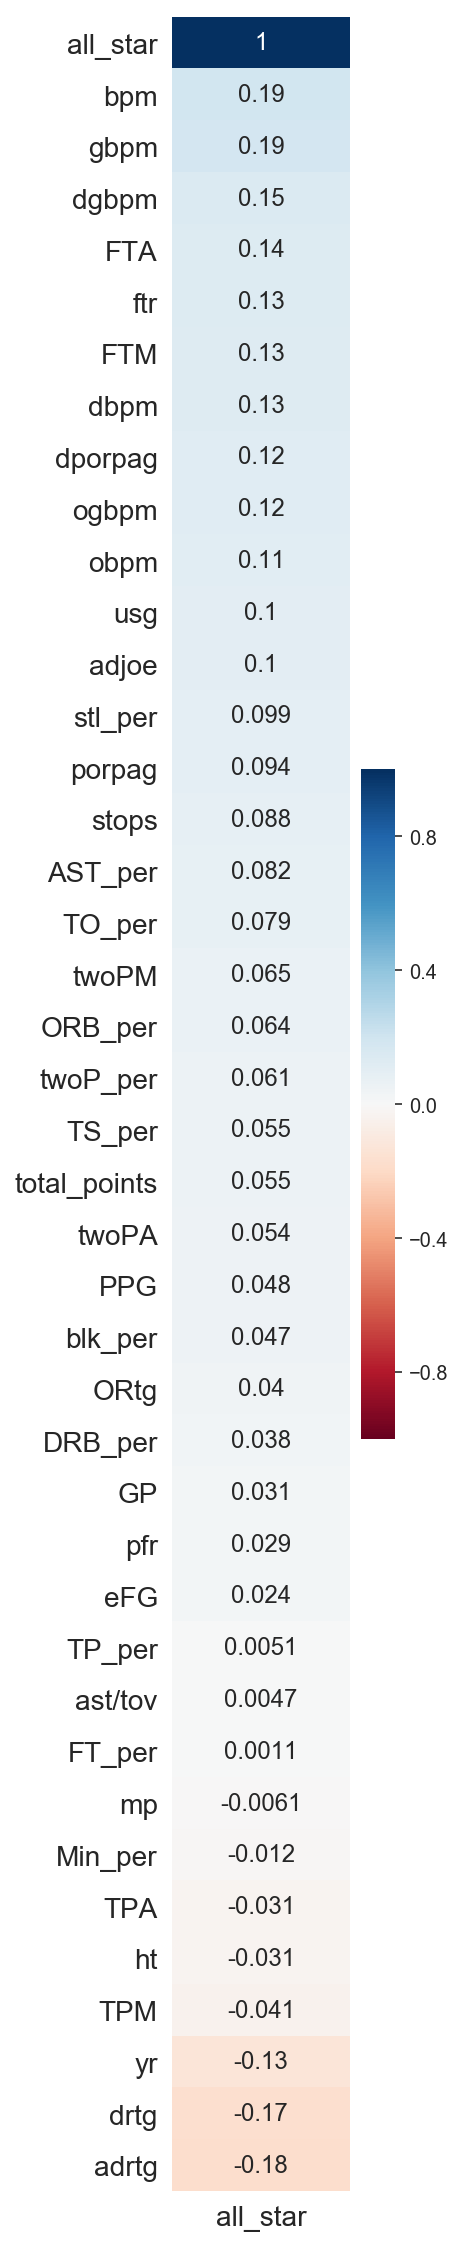

In [119]:
#Looking at correlation heatmap for numerical columns versus the all_star column
plt.figure(figsize = (2,20))

sns.heatmap(single_season_df.drop(columns = corr_drop).corr()[['all_star']].sort_values(by = 'all_star', ascending = False), 
            annot = True, 
            cmap = 'RdBu',
            vmin = -1,
           annot_kws={"size":12})
plt.xticks(size = 14)
plt.yticks(size = 14);



Very few numerical columns are highly correlated with becoming an All-Star. In fact, the majority of columns show relatively no correlation at all. This may make it difficult for models to predict the target variable correctly.

### Creating Dummy Columns

We are going to turn the conference and position columns into dummy variables before modeling the data in order to represent the categorical features.

In [120]:
#creating dummy columns
dummy_columns = ['conference', 'Pos']

single_season_df = pd.get_dummies(data = single_season_df, columns = dummy_columns, drop_first= True)

### More EDA After Modeling

We are going to reduce some of the features that were intially used in the model. Several of the features have some overlap in the way they are calculated so should be able to be removed. 

- FTM, FTA and FT_per 
- twoPM, twoPA and twoP_per
- TPM, TPA and TP_per

Before we remove the columns that are not percentages, we are going to create a new percentage column using Bayesian statistics. There is no mininum number of shot attempts in the original calculations so someone who has only taken a few shots and made a higher percentage will be weighted the same as someone who took many field goal attempts with a lower percentage. We want to make sure our percentage data isn't skewed due to this case. We are going to use prior knowledge along with a likelihood function to calculate the posterior distribution for each field goal type. We will then calculate the the maximum a posteriori (MAP) estimate of for each field goal type.

**Free Throws**

Our prior belief for free throws is that out of 100 shots a player would make 70 free throws. This data was calculated by averaging all free throw attempts in college over the last 10 years. The calculation can be seen in the **Data Scrape - Team Stats for Bayes Analysis** notebook.

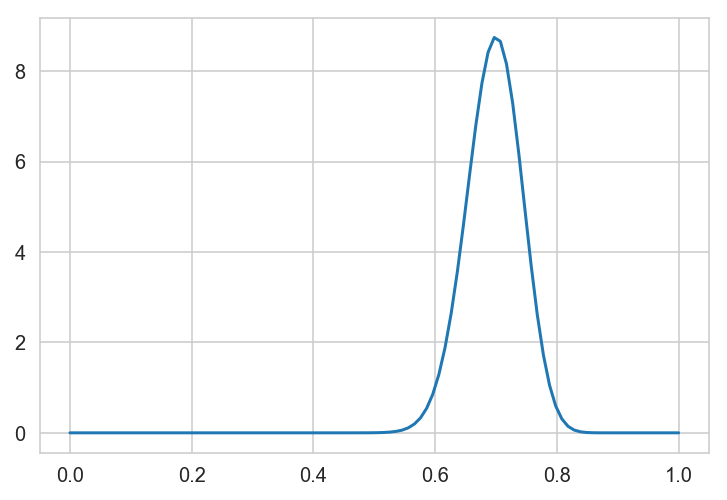

In [121]:
#Graphically showing the prior
alpha_prior = 71
beta_prior = 31

distn = stats.beta(alpha_prior, beta_prior)

x_axis = np.linspace(0, 1, 100)

plt.plot(x_axis, distn.pdf(x_axis));

The graph above shows the beta distribution for free throw percentage given the prior knowledge that 70% is the historical average. You can see that the peak of the distribution graph occurs around 70%.

In [122]:
single_season_df.head()

,player_name,school,GP,Min_per,ORtg,usg,eFG,TS_per,ORB_per,DRB_per,AST_per,TO_per,FTM,FTA,FT_per,twoPM,twoPA,twoP_per,TPM,TPA,TP_per,blk_per,stl_per,ftr,yr,ht,porpag,adjoe,pfr,year,pid,ast/tov,pick,drtg,adrtg,dporpag,stops,bpm,obpm,dbpm,gbpm,mp,ogbpm,dgbpm,all_star,total_points,PPG,conference_B10,conference_B12,conference_BE,conference_Non_major,conference_P10,conference_P12,conference_SEC,Pos_F,Pos_G
0,Charles Jenkins,Hofstra,32,92.4,123.2,28.7,57.7,62.93,1.6,8.6,31.3,12.8,179,217,0.825,176,317,0.555,63,152,0.414,1.8,2.7,46.3,4,75,6.65016,136.761,2.1,2011,57,2.112628,44.0,107.8070,106.3460,2.64050,192.184,8.13409,9.32934,-1.195250,8.301,37.4063,8.400,-0.099,0,720,22.50,0,0,0,1,0,0,0,0,1
1,Richard Hendrix,Alabama,32,73.1,117.4,26.2,60.1,59.36,13.1,23.5,11.5,12.3,108,201,0.537,227,376,0.604,2,7,0.286,7.2,2.4,52.5,3,81,4.77910,130.431,3.8,2008,65,0.927275,49.0,96.4548,91.9969,3.63708,236.544,10.16180,5.61840,4.543410,9.197,30.6250,7.032,2.165,0,568,17.75,0,0,0,0,0,0,1,1,0
2,Vernon Macklin,Florida,37,59.7,107.5,24.3,59.3,57.77,10.9,15.0,7.7,17.7,46,102,0.451,191,322,0.593,0,0,0.000,3.1,0.9,31.7,4,82,2.82126,118.954,4.0,2011,91,0.476185,52.0,97.7281,93.3167,2.78675,155.033,4.01017,2.54894,1.461230,4.129,24.4595,3.524,0.605,0,428,11.57,0,0,0,0,0,0,1,1,0
3,Maarty Leunen,Oregon,32,85.8,135.3,19.0,66.4,69.59,7.9,23.5,15.5,14.1,112,142,0.789,98,161,0.609,59,120,0.492,1.1,1.5,50.5,4,81,6.62117,140.360,2.8,2008,94,1.800000,54.0,102.8660,97.1158,3.52963,222.794,11.15260,9.23392,1.918640,9.765,34.7188,8.596,1.169,0,485,15.16,0,0,0,0,1,0,0,1,0
4,Malik Hairston,Oregon,31,75.4,121.7,23.3,60.3,63.04,5.8,12.6,14.0,14.3,101,138,0.732,124,215,0.577,52,120,0.433,2.9,1.2,41.2,4,78,5.33399,134.172,3.7,2008,98,1.199977,48.0,106.9630,100.4400,2.84072,164.953,7.53980,6.88089,0.658901,7.456,31.4839,7.095,0.361,0,505,16.29,0,0,0,0,1,0,0,0,1


In [123]:
#create misses column
single_season_df['FT_misses'] = single_season_df['FTA'] - single_season_df['FTM']

In [124]:
single_season_df['new_FTM'] = single_season_df['FTM'] + alpha_prior
single_season_df['new_FT_misses'] = single_season_df['FT_misses'] + beta_prior

In [125]:
#Creating MAP for Free Throw Average
single_season_df['new_FT_avg'] = (single_season_df['new_FTM'] - 1) / (single_season_df['new_FTM'] + single_season_df['new_FT_misses'] - 2)


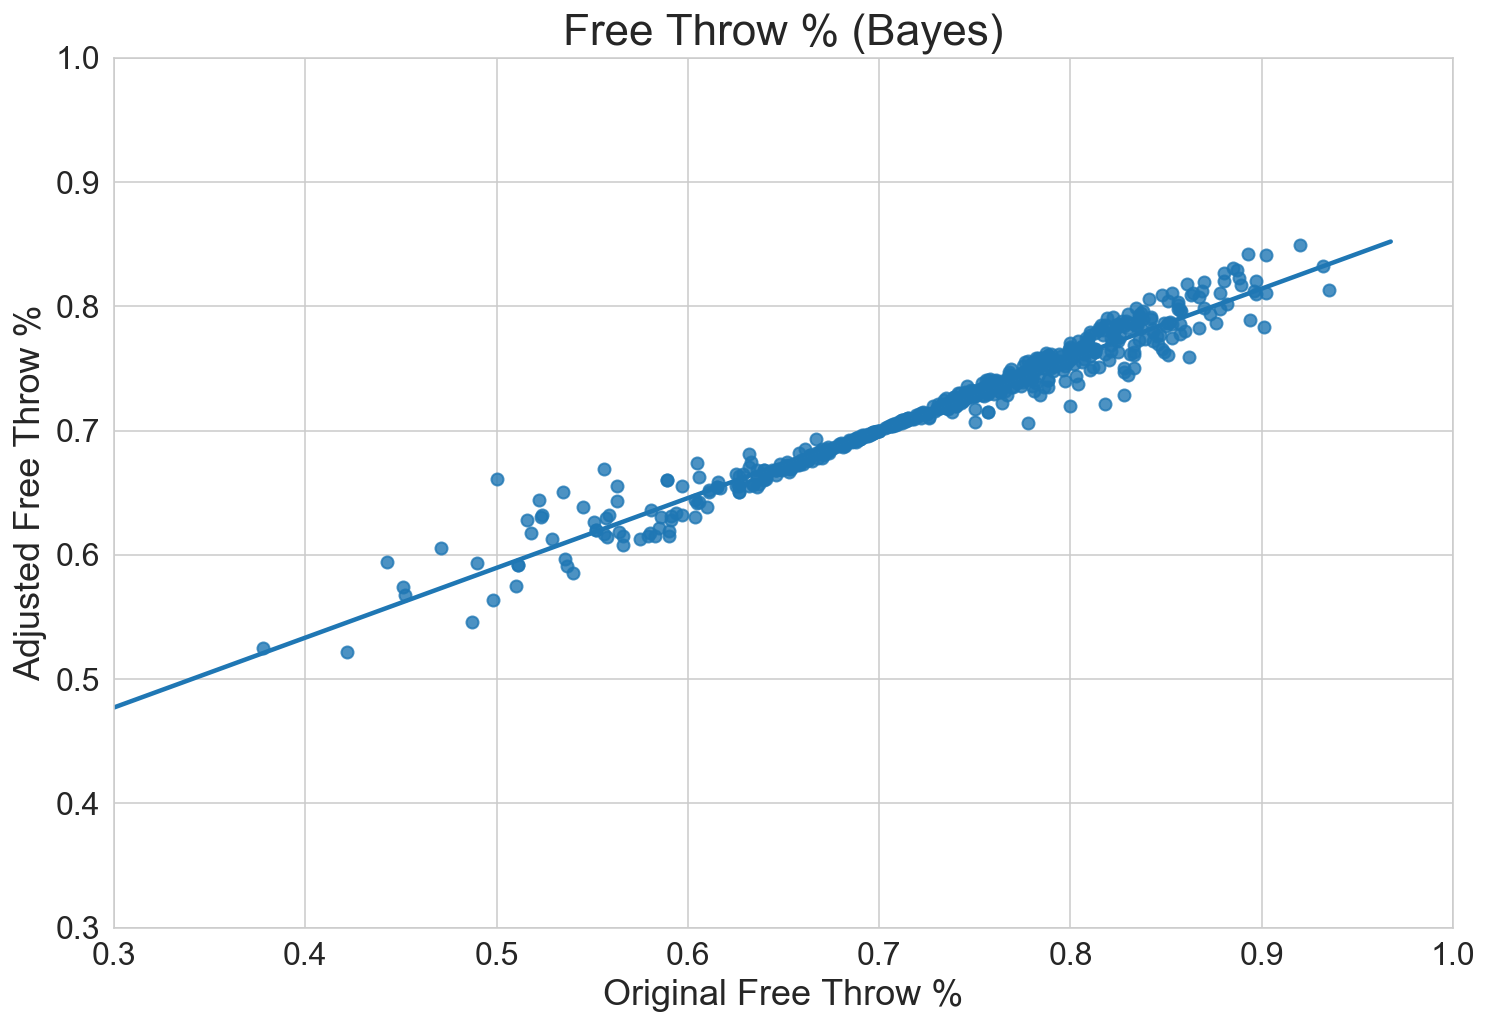

In [126]:
plt.figure(figsize = (12, 8))
sns.regplot(single_season_df['FT_per'], single_season_df['new_FT_avg'], ci = False)
plt.xlabel('Original Free Throw %', size = 18)
plt.ylabel('Adjusted Free Throw %', size = 18)
plt.title('Free Throw % (Bayes)', size = 22)
plt.xticks(size = 16)
plt.yticks(size = 16)
plt.xlim(.3, 1)
plt.ylim(.3, 1);


Utilizing the Beta distribution to calculate the Bayesian MAP estimate on free throw percentage produced the results above. The Beta distribution will adjust the percentage more for players with extremely high or low rates. Values around 70% did not change as they had a similar value to the prior.

---

**3-point Shots**

Our prior belief for three point shots is that out of 100 shots a player would make 35 free throws. This data was calculated by averaging all three point attempts in college over the last 10 years. The calculation can be seen in the **Data Scrape - Team Stats for Bayes Analysis** notebook.


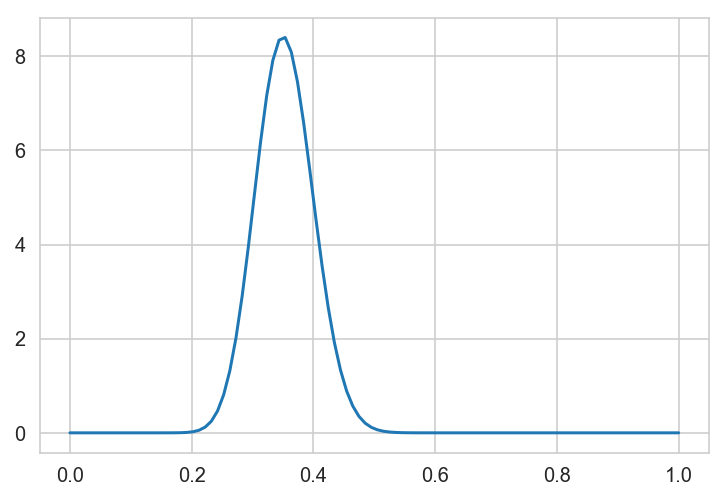

In [127]:
#Graphically showing the prior
alpha_prior = 36
beta_prior = 66

distn = stats.beta(alpha_prior, beta_prior)

x_axis = np.linspace(0, 1, 100)

plt.plot(x_axis, distn.pdf(x_axis));

The graph above shows the beta distribution for 3-point percentage given the prior knowledge that 35% is the historical average. You can see that the peak of the distribution graph occurs around 35%.

In [128]:
#create misses column
single_season_df['3P_misses'] = single_season_df['TPA'] - single_season_df['TPM']

In [129]:
single_season_df['new_TPM'] = single_season_df['TPM'] + alpha_prior
single_season_df['new_3P_misses'] = single_season_df['3P_misses'] + beta_prior

In [130]:
#Creating MAP for 3 Point Average
single_season_df['new_3P_avg'] = (single_season_df['new_TPM'] - 1) / (single_season_df['new_TPM'] + single_season_df['new_3P_misses'] - 2)


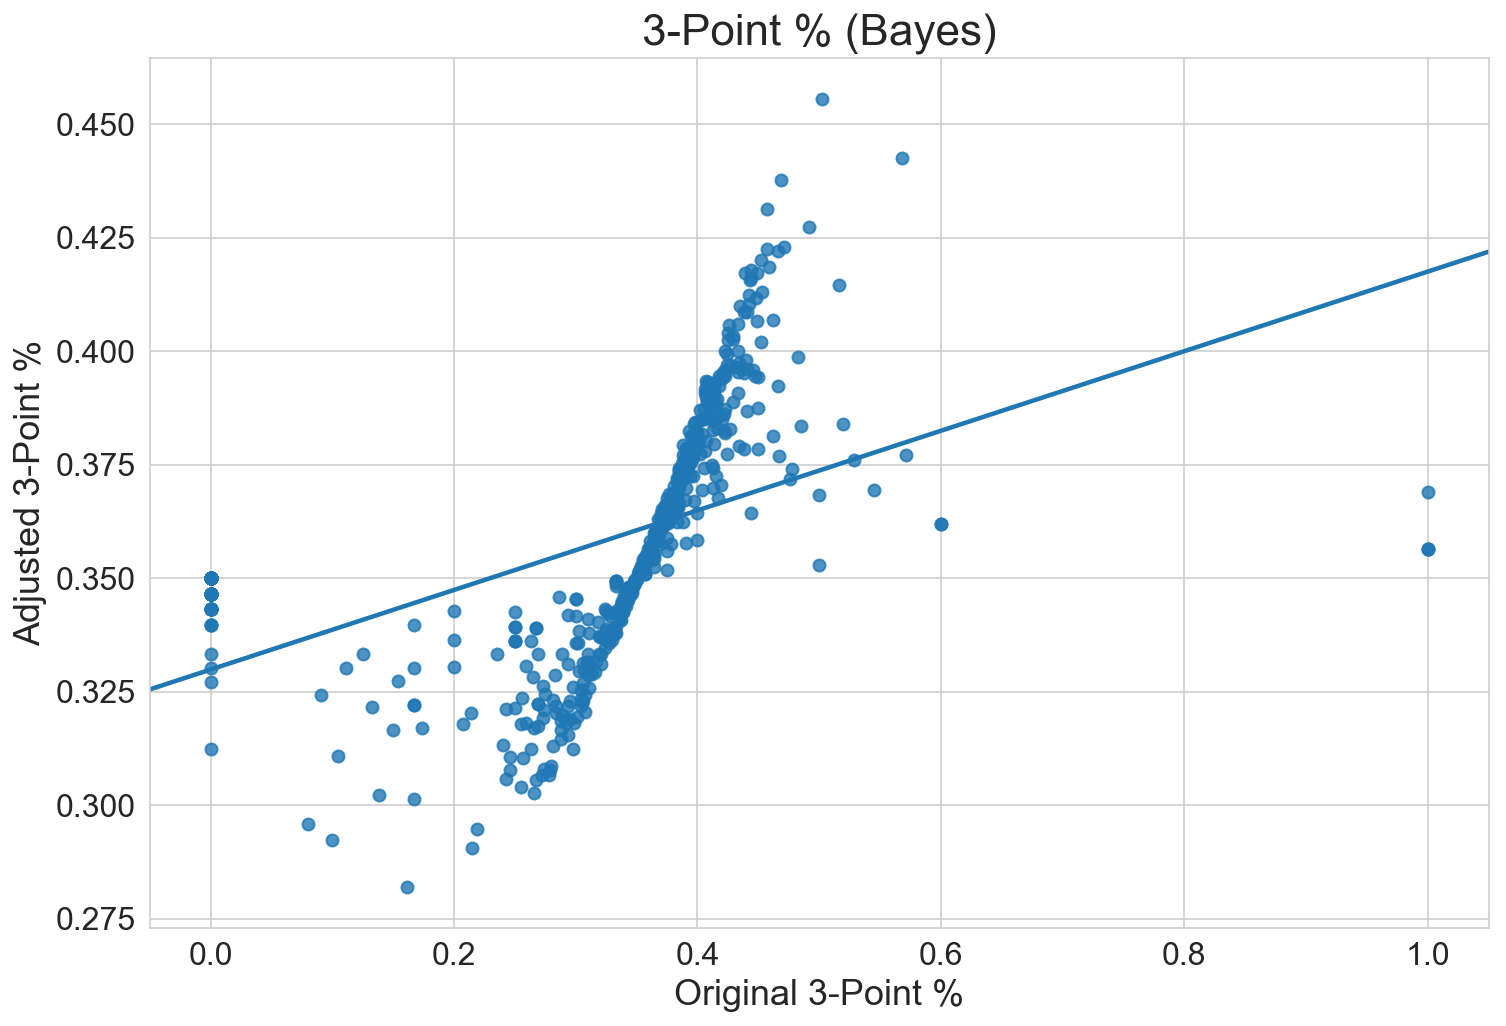

In [131]:
plt.figure(figsize = (12, 8))
sns.regplot(single_season_df['TP_per'], single_season_df['new_3P_avg'], ci = False)
plt.xlabel('Original 3-Point %', size = 18)
plt.ylabel('Adjusted 3-Point %', size = 18)
plt.title('3-Point % (Bayes)', size = 22)
plt.xticks(size = 16)
plt.yticks(size = 16);


Adjusting 3-point percentages by utilizing the Beta distribution to calculate the Bayesian MAP estimate produced the results above. The Beta distribution will adjust the percentage more for players with extremely high or low 3-point percentages. For example, players that had a 100% original shooting percentage were adjusted down and ones that had a 0% were adjusted up. Values around 35% did not change as they had a similar value to the prior.

---

**2-Point Shots**

Our prior belief for two point shots is that out of 100 shots a player would make 49 two point shots. This data was calculated by averaging all two point attempts in college over the last 10 years. The calculation can be seen in the **Data Scrape - Team Stats for Bayes Analysis** notebook.

twoPM, twoPA and twoP_per

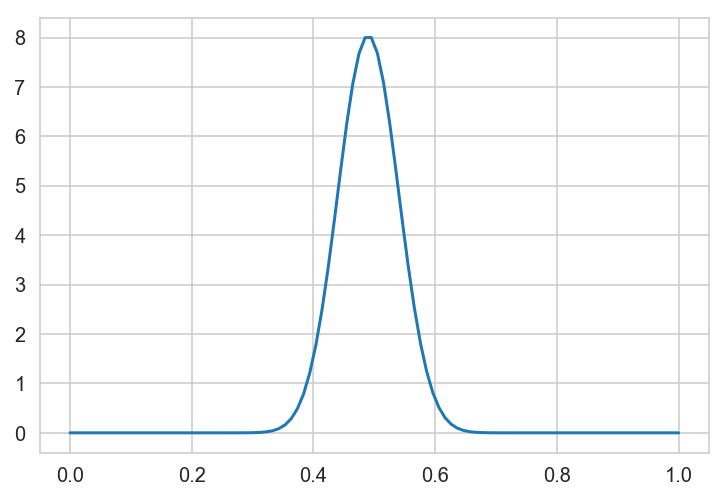

In [132]:
#Graphically showing the prior
alpha_prior = 50
beta_prior = 52

distn = stats.beta(alpha_prior, beta_prior)

x_axis = np.linspace(0, 1, 100)

plt.plot(x_axis, distn.pdf(x_axis));

The graph above shows the beta distribution for 2-point percentage given the prior knowledge that 49% is the historical average. You can see that the peak of the distribution graph occurs around 49%.

In [133]:
#create misses column
single_season_df['2P_misses'] = single_season_df['twoPA'] - single_season_df['twoPM']

In [134]:
single_season_df['new_2PM'] = single_season_df['twoPM'] + alpha_prior
single_season_df['new_2P_misses'] = single_season_df['2P_misses'] + beta_prior

In [135]:
#Creating MAP for 3 Point Average
single_season_df['new_2P_avg'] = (single_season_df['new_2PM'] - 1) / (single_season_df['new_2PM'] + single_season_df['new_2P_misses'] - 2)


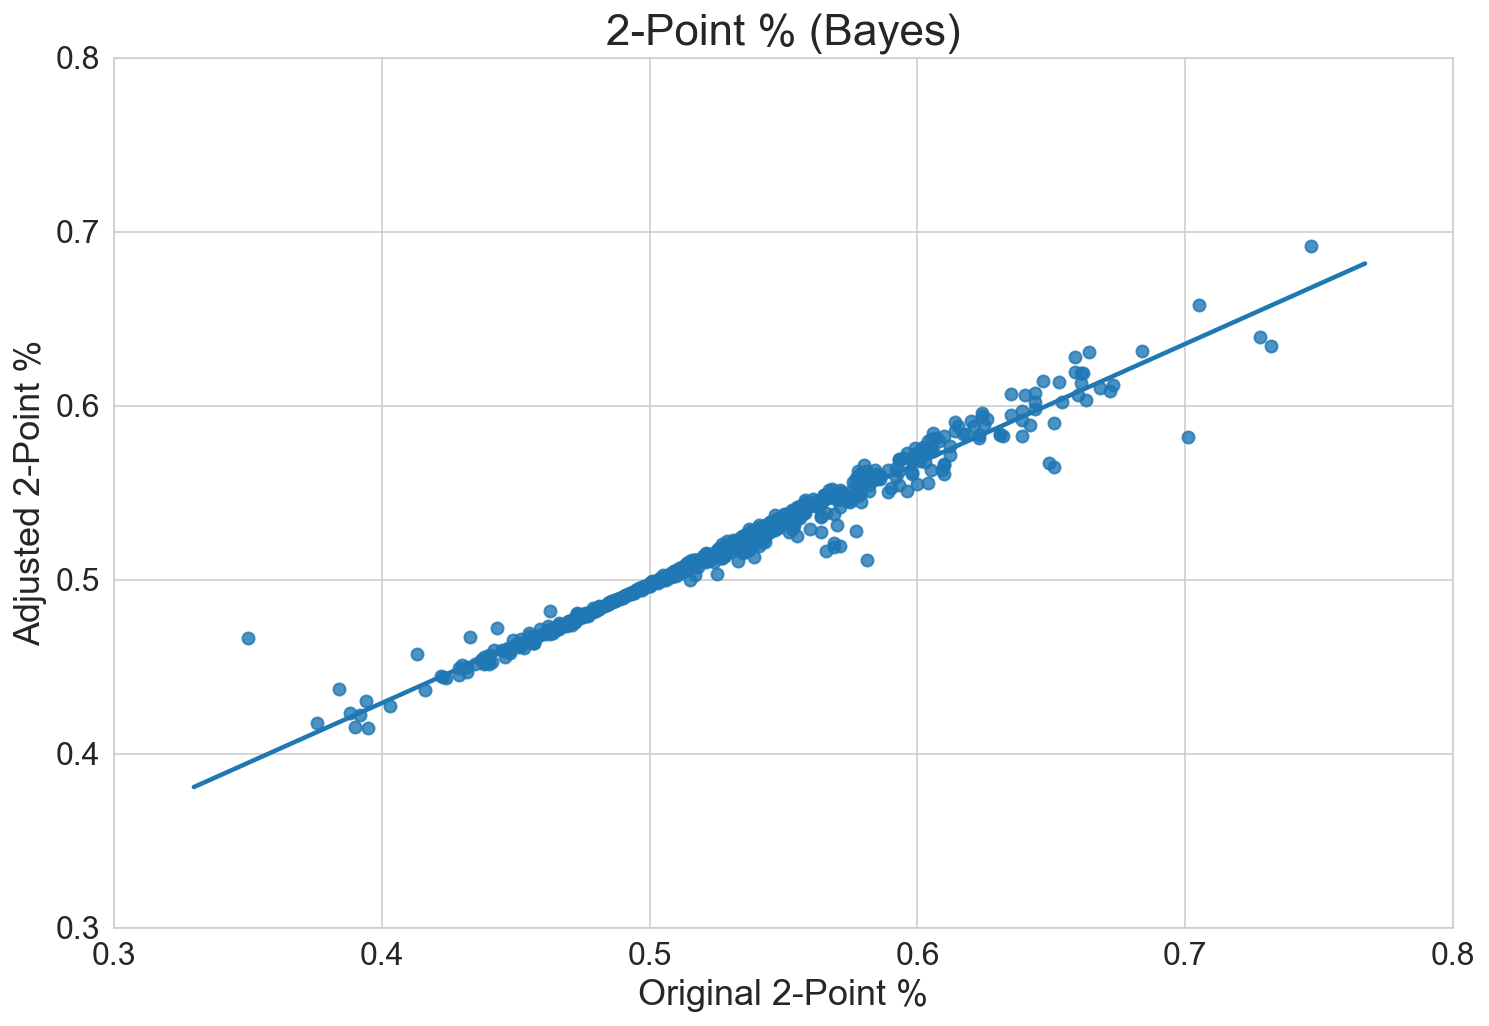

In [136]:
plt.figure(figsize = (12, 8))
sns.regplot(single_season_df['twoP_per'], single_season_df['new_2P_avg'], ci = False)
plt.title('2-Point % (Bayes)', size = 22)
plt.xlabel('Original 2-Point %', size = 18)
plt.ylabel('Adjusted 2-Point %', size = 18)
plt.xticks(size = 16)
plt.yticks(size = 16)
plt.xlim(.3, .8)
plt.ylim(.3, .8);


Adjusting 2-point percentages by utilizing the Beta distribution to calculate the Bayesian MAP estimate produced the results above. The Beta distribution will adjust the percentage more for players with extremely high or low 2-point percentages. For example, players that had an original shooting percentage above 70% were adjusted down and ones that had below 40% were adjusted up. Values around 50% did not change as they had a similar value to the prior.


In [137]:
single_season_df.head()

,player_name,school,GP,Min_per,ORtg,usg,eFG,TS_per,ORB_per,DRB_per,AST_per,TO_per,FTM,FTA,FT_per,twoPM,twoPA,twoP_per,TPM,TPA,TP_per,blk_per,stl_per,ftr,yr,ht,porpag,adjoe,pfr,year,pid,ast/tov,pick,drtg,adrtg,dporpag,stops,bpm,obpm,dbpm,gbpm,mp,ogbpm,dgbpm,all_star,total_points,PPG,conference_B10,conference_B12,conference_BE,conference_Non_major,conference_P10,conference_P12,conference_SEC,Pos_F,Pos_G,FT_misses,new_FTM,new_FT_misses,new_FT_avg,3P_misses,new_TPM,new_3P_misses,new_3P_avg,2P_misses,new_2PM,new_2P_misses,new_2P_avg
0,Charles Jenkins,Hofstra,32,92.4,123.2,28.7,57.7,62.93,1.6,8.6,31.3,12.8,179,217,0.825,176,317,0.555,63,152,0.414,1.8,2.7,46.3,4,75,6.65016,136.761,2.1,2011,57,2.112628,44.0,107.8070,106.3460,2.64050,192.184,8.13409,9.32934,-1.195250,8.301,37.4063,8.400,-0.099,0,720,22.50,0,0,0,1,0,0,0,0,1,38,250,69,0.785489,89,99,155,0.388889,141,226,193,0.539568
1,Richard Hendrix,Alabama,32,73.1,117.4,26.2,60.1,59.36,13.1,23.5,11.5,12.3,108,201,0.537,227,376,0.604,2,7,0.286,7.2,2.4,52.5,3,81,4.77910,130.431,3.8,2008,65,0.927275,49.0,96.4548,91.9969,3.63708,236.544,10.16180,5.61840,4.543410,9.197,30.6250,7.032,2.165,0,568,17.75,0,0,0,0,0,0,1,1,0,93,179,124,0.591362,5,38,71,0.345794,149,277,201,0.579832
2,Vernon Macklin,Florida,37,59.7,107.5,24.3,59.3,57.77,10.9,15.0,7.7,17.7,46,102,0.451,191,322,0.593,0,0,0.000,3.1,0.9,31.7,4,82,2.82126,118.954,4.0,2011,91,0.476185,52.0,97.7281,93.3167,2.78675,155.033,4.01017,2.54894,1.461230,4.129,24.4595,3.524,0.605,0,428,11.57,0,0,0,0,0,0,1,1,0,56,117,87,0.574257,0,36,66,0.350000,131,241,183,0.568720
3,Maarty Leunen,Oregon,32,85.8,135.3,19.0,66.4,69.59,7.9,23.5,15.5,14.1,112,142,0.789,98,161,0.609,59,120,0.492,1.1,1.5,50.5,4,81,6.62117,140.360,2.8,2008,94,1.800000,54.0,102.8660,97.1158,3.52963,222.794,11.15260,9.23392,1.918640,9.765,34.7188,8.596,1.169,0,485,15.16,0,0,0,0,1,0,0,1,0,30,183,61,0.752066,61,95,127,0.427273,63,148,115,0.563218
4,Malik Hairston,Oregon,31,75.4,121.7,23.3,60.3,63.04,5.8,12.6,14.0,14.3,101,138,0.732,124,215,0.577,52,120,0.433,2.9,1.2,41.2,4,78,5.33399,134.172,3.7,2008,98,1.199977,48.0,106.9630,100.4400,2.84072,164.953,7.53980,6.88089,0.658901,7.456,31.4839,7.095,0.361,0,505,16.29,0,0,0,0,1,0,0,0,1,37,172,68,0.718487,68,88,134,0.395455,91,174,143,0.549206


In [138]:
np.round(single_season_df.groupby('all_star').mean().T, 2)

all_star,0,1
GP,33.60,34.27
Min_per,73.92,73.11
ORtg,112.88,114.33
usg,24.60,26.55
eFG,54.20,54.77
TS_per,57.79,58.91
ORB_per,6.95,8.17
DRB_per,16.40,17.41
AST_per,15.77,19.24
TO_per,16.38,17.64


#### Saving Files for Modeling

In [139]:
#turning dataframe to CSV to use in separate notebook for modeling.
single_season_df.to_csv('../Data_Files/model_single_season.csv')

In [140]:
#creating file with Bayes columns
single_season_df.to_csv('../Data_Files/model_single_season_bayes.csv')